In [22]:
library(tidyr)
library(tidyverse)
library(dplyr)
library(ggplot2)
library(readr)
library(pscl)
library(caret)
library(MASS)

In [23]:
getwd()

[1] "/home/jupyter"

In [24]:
all_models_board_cv <- function(DT_train, DT_test){
        
        set.seed(123)
        rand_ind = groupKFold(c(1:dim(DT_train)[1]), k = 10)
        
        sm_Poiss <- list()
        sm_NB <- list()
        sm_ZIP_Poiss <- list()
        sm_ZIP_NB <- list()
        sm_hurdle <- list()
        
        RMSE_Poiss = 0
        RMSE_NB = 0
        RMSE_ZIP_Poiss = 0
        RMSE_ZIP_NB = 0
        RMSE_hurdle = 0
        
        k_fold_pred_Poiss <- list()
        k_fold_pred_NB <- list()
        k_fold_pred_ZIP_Poiss <- list()
        k_fold_pred_ZIP_NB <- list()
        k_fold_pred_hurdle <- list()
        
        predictions_Poiss = 0
        predictions_NB = 0
        predictions_ZIP_Poiss = 0
        predictions_ZIP_NB = 0
        predictions_hurdle = 0
        
        ind_Poiss = 0
        #ind_QPoiss = 0
        ind_NB = 0
        ind_ZIP_Poiss = 0
        ind_ZIP_NB = 0
        ind_hurdle = 0
                       
        for(i in 1:10){
                                           
            df = DT_train[rand_ind[[i]],]
            df_test = DT_train[-rand_ind[[i]],]
                       
            Poiss.fit = glm(board_count ~ ., data = df, family = 'poisson')
                         
            NB.fit = glm.nb(board_count ~ ., data = df)
                
            ZIP.Poiss = zeroinfl(board_count ~ . | hour + service_kind,
                               data = df, dist = 'poisson', link = 'logit')
            
            ZIP.NB = zeroinfl(board_count ~ . |  hour + service_kind,
                               data = df, dist = 'negbin', link = 'logit')
                
            hurdle.fit = hurdle(board_count ~ . |  hour + service_kind,
                                data = df, dist = 'poisson', zero.dist = 'binomial', link = 'logit')
                
                
            sm_Poiss[[i]] = Poiss.fit
            sm_NB[[i]] = NB.fit
            sm_ZIP_Poiss[[i]] = ZIP.Poiss
            sm_ZIP_NB[[i]] = ZIP.NB
            sm_hurdle[[i]] = hurdle.fit
                
            k_fold_pred_Poiss[[i]] = predict(Poiss.fit, df_test, type = "response")
            k_fold_pred_NB[[i]] = predict(NB.fit, df_test, type = "response")
            k_fold_pred_ZIP_Poiss[[i]] = predict(ZIP.Poiss, df_test, type = "response")
            k_fold_pred_ZIP_NB[[i]] = predict(ZIP.NB, df_test, type = "response")
            k_fold_pred_hurdle[[i]] = predict(hurdle.fit, df_test, type = "response")
                
            RMSE_Poiss[i] = sqrt(mean((df_test$board_count - k_fold_pred_Poiss[[i]])^{2}))
            RMSE_NB[i] = sqrt(mean((df_test$board_count - k_fold_pred_NB[[i]])^{2}))
            RMSE_ZIP_Poiss[i] = sqrt(mean((df_test$board_count - k_fold_pred_ZIP_Poiss[[i]])^{2}))
            RMSE_ZIP_NB[i] = sqrt(mean((df_test$board_count - k_fold_pred_ZIP_NB[[i]])^{2}))
            RMSE_hurdle[i] = sqrt(mean((df_test$board_count - k_fold_pred_hurdle[[i]])^{2}))
        }
                                           
        ind_Poiss = which(RMSE_Poiss == min(RMSE_Poiss), arr.ind = T)
        ind_NB = which(RMSE_NB == min(RMSE_NB), arr.ind = T)
        ind_ZIP_Poiss = which(RMSE_ZIP_Poiss == min(RMSE_ZIP_Poiss), arr.ind = T)
        ind_ZIP_NB = which(RMSE_ZIP_NB == min(RMSE_ZIP_NB), arr.ind = T)
        ind_hurdle = which(RMSE_hurdle == min(RMSE_hurdle), arr.ind = T)
            
        train_RMSE_Poiss = RMSE_Poiss[ind_Poiss]
        train_RMSE_NB = RMSE_NB[ind_NB]
        train_RMSE_ZIP_Poiss = RMSE_ZIP_Poiss[ind_ZIP_Poiss]
        train_RMSE_ZIP_NB = RMSE_ZIP_NB[ind_ZIP_NB]
        train_RMSE_hurdle = RMSE_hurdle[ind_hurdle]
            
        model_Poiss = sm_Poiss[[ind_Poiss]]
        model_NB = sm_NB[[ind_NB]]
        model_ZIP_Poiss = sm_ZIP_Poiss[[ind_ZIP_Poiss]]
        model_ZIP_NB = sm_ZIP_NB[[ind_ZIP_NB]]
        model_hurdle = sm_hurdle[[ind_hurdle]]
        
        model_Poiss_AIC = AIC(model_Poiss)
        model_NB_AIC = AIC(model_NB)
        model_ZIP_Poiss_AIC = AIC(model_ZIP_Poiss)
        model_ZIP_NB_AIC = AIC(model_ZIP_NB)
        model_hurdle_AIC = AIC(model_hurdle)
        
        AICs = c(model_Poiss_AIC, model_NB_AIC,
                 model_ZIP_Poiss_AIC, model_ZIP_NB_AIC, model_hurdle_AIC)
    
        AIC_ind = which(AICs == min(AICs), arr.ind = T)
        
        Model_Name = c('Poisson', 'Negative_Binomial',
                       'ZIP_Poisson', 'ZIP_Negative_Binomial', 'Hurdle_Poisson_and_Binomial')
        
        Models_AIC = data.frame(cbind(Model_Name, c(model_Poiss_AIC, model_NB_AIC,
                                                    model_ZIP_Poiss_AIC, model_ZIP_NB_AIC, model_hurdle_AIC)))
        
        Selected_Model = Model_Name[AIC_ind]
                          
        test <- DT_test[ , -c(4)]
            
        predictions_Poiss = predict(model_Poiss, test, type = "response")
        predictions_NB = predict(model_NB, test, type = "response")
        predictions_ZIP_Poiss = predict(model_ZIP_Poiss, test, type = "response")
        predictions_ZIP_NB = predict(model_ZIP_NB, test, type = "response")
        predictions_hurdle = predict(model_hurdle, test, type = "response")
            
        test_RMSE_Poiss = sqrt(mean((DT_test$board_count - predictions_Poiss)^{2}))
        test_RMSE_NB = sqrt(mean((DT_test$board_count - predictions_NB)^{2}))
        test_RMSE_ZIP_Poiss = sqrt(mean((DT_test$board_count - predictions_ZIP_Poiss)^{2}))
        test_RMSE_ZIP_NB = sqrt(mean((DT_test$board_count - predictions_ZIP_NB)^{2}))
        test_RMSE_hurdle = sqrt(mean((DT_test$board_count - predictions_hurdle)^{2}))
            
        Train_RMSE = data.frame(cbind('Poiss' = train_RMSE_Poiss, 'NB' = train_RMSE_NB,
                                      'ZIP_Poiss' = train_RMSE_ZIP_Poiss, 'ZIP_NB' = train_RMSE_ZIP_NB, 'hurdle' = train_RMSE_hurdle))
    
        Test_RMSE = data.frame(cbind('Poiss' = test_RMSE_Poiss, 'NB' = test_RMSE_NB,
                                     'ZIP_Poiss' = test_RMSE_ZIP_Poiss, 'ZIP_NB' = test_RMSE_ZIP_NB, 'hurdle' = test_RMSE_hurdle))
                    
        Models = list('Poiss' = model_Poiss, 'NB' = model_NB,
                      'ZIP_Poiss' = model_ZIP_Poiss, 'ZIP_NB' = model_ZIP_NB, 'hurdle' = model_hurdle)
            
        Predictions = data.frame(cbind('Poiss' = predictions_Poiss, 
                                       'NB' = predictions_NB,
                                       'ZIP_Poiss' = predictions_ZIP_Poiss,
                                       'ZIP_NB' = predictions_ZIP_NB,
                                       'hurdle' = predictions_hurdle,
                                       'count' = DT_test$board_count))
                      
        performance <- list("train_RMSEs" = Train_RMSE,
                            "test_RMSEs" = Test_RMSE,
                            "Models_AIC" = Models_AIC,
                            "Selected_Model" = Selected_Model,
                            "Trained_Models" = Models,
                            "Predicted" = Predictions)
        return(performance)    
}

In [25]:
data_split <- function(DT, prop, set){
    n_rows = dim(DT)[1]
    train_set_size = floor(n_rows*prop)
    
    set.seed(123)
    
    train = sample((1:n_rows), train_set_size, replace = F)
    
    if(set == 'train'){
        train_set = DT[train, ]
        return(train_set)
    }
    else{
        test_set = DT[-train,]
        return(test_set)
    }
}

## Route1 Direction 1

### Pre-lockdown

In [34]:
Pre_lock_route1_dir1_bus_stop_124 = read_csv('/home/jupyter/Data_for_regression/Board_Count/route1_dir1/Pre_lock_route1_dir1_bus_stop_124.csv')
Pre_lock_route1_dir1_bus_stop_124 = Pre_lock_route1_dir1_bus_stop_124[ , -c(1)]
Pre_lock_route1_dir1_bus_stop_124$board_count = round(Pre_lock_route1_dir1_bus_stop_124$board_count)
Pre_lock_route1_dir1_bus_stop_124$month = factor(Pre_lock_route1_dir1_bus_stop_124$month)
Pre_lock_route1_dir1_bus_stop_124$service_kind = factor(Pre_lock_route1_dir1_bus_stop_124$service_kind)
Pre_lock_route1_dir1_bus_stop_124$hour = factor(Pre_lock_route1_dir1_bus_stop_124$hour)

Pre_lock_route1_dir1_bus_stop_136 = read_csv('/home/jupyter/Data_for_regression/Board_Count/route1_dir1/Pre_lock_route1_dir1_bus_stop_136.csv')
Pre_lock_route1_dir1_bus_stop_136 = Pre_lock_route1_dir1_bus_stop_136[ , -c(1)]
Pre_lock_route1_dir1_bus_stop_136$board_count = round(Pre_lock_route1_dir1_bus_stop_136$board_count)
Pre_lock_route1_dir1_bus_stop_136$month = factor(Pre_lock_route1_dir1_bus_stop_136$month)
Pre_lock_route1_dir1_bus_stop_136$service_kind = factor(Pre_lock_route1_dir1_bus_stop_136$service_kind)
Pre_lock_route1_dir1_bus_stop_136$hour = factor(Pre_lock_route1_dir1_bus_stop_136$hour)

Pre_lock_route1_dir1_bus_stop_1358 = read_csv('/home/jupyter/Data_for_regression/Board_Count/route1_dir1/Pre_lock_route1_dir1_bus_stop_1358.csv')
Pre_lock_route1_dir1_bus_stop_1358 = Pre_lock_route1_dir1_bus_stop_1358[ , -c(1)]
Pre_lock_route1_dir1_bus_stop_1358$board_count = round(Pre_lock_route1_dir1_bus_stop_1358$board_count)
Pre_lock_route1_dir1_bus_stop_1358$month = factor(Pre_lock_route1_dir1_bus_stop_1358$month)
Pre_lock_route1_dir1_bus_stop_1358$service_kind = factor(Pre_lock_route1_dir1_bus_stop_1358$service_kind)
Pre_lock_route1_dir1_bus_stop_1358$hour = factor(Pre_lock_route1_dir1_bus_stop_1358$hour)

#Pre_lock_route1_dir1_bus_stop_1487 = read_csv('/home/jupyter/Data_for_regression/Board_Count/route1_dir1/Pre_lock_route1_dir1_bus_stop_1487.csv')
#Pre_lock_route1_dir1_bus_stop_1487 = Pre_lock_route1_dir1_bus_stop_1487[ , -c(1)]
#Pre_lock_route1_dir1_bus_stop_1487$board_count = round(Pre_lock_route1_dir1_bus_stop_1487$board_count)
#Pre_lock_route1_dir1_bus_stop_1487$month = factor(Pre_lock_route1_dir1_bus_stop_1487$month)
#Pre_lock_route1_dir1_bus_stop_1487$service_kind = factor(Pre_lock_route1_dir1_bus_stop_1487$service_kind)
#Pre_lock_route1_dir1_bus_stop_1487$hour = factor(Pre_lock_route1_dir1_bus_stop_1487$hour)

Pre_lock_route1_dir1_bus_stop_1582 = read_csv('/home/jupyter/Data_for_regression/Board_Count/route1_dir1/Pre_lock_route1_dir1_bus_stop_1582.csv')
Pre_lock_route1_dir1_bus_stop_1582 = Pre_lock_route1_dir1_bus_stop_1582[ , -c(1)]
Pre_lock_route1_dir1_bus_stop_1582$board_count = round(Pre_lock_route1_dir1_bus_stop_1582$board_count)
Pre_lock_route1_dir1_bus_stop_1582$month = factor(Pre_lock_route1_dir1_bus_stop_1582$month)
Pre_lock_route1_dir1_bus_stop_1582$service_kind = factor(Pre_lock_route1_dir1_bus_stop_1582$service_kind)
Pre_lock_route1_dir1_bus_stop_1582$hour = factor(Pre_lock_route1_dir1_bus_stop_1582$hour)

head(Pre_lock_route1_dir1_bus_stop_136)

Warning message:
“Missing column names filled in: 'X1' [1]”

── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_double(),
  month = col_double(),
  service_kind = col_character(),
  hour = col_double(),
  board_count = col_double(),
  temp = col_double(),
  precip = col_double(),
  surrounding_board_count = col_double()
)


Warning message:
“Missing column names filled in: 'X1' [1]”

── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_double(),
  month = col_double(),
  service_kind = col_character(),
  hour = col_double(),
  board_count = col_double(),
  temp = col_double(),
  precip = col_double(),
  surrounding_board_count = col_double()
)


Warning message:
“Missing column names filled in: 'X1' [1]”

── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_double(),
  month = col_double(),
  service_kind = col_character(),
  hour = col_double(),
  bo

month,service_kind,hour,board_count,temp,precip,surrounding_board_count
<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,weekday,0,0,0.2976687,0.09266714,0.00
1,weekday,0,0,0.2976687,0.09266714,0.02
1,weekday,0,0,0.2976687,0.09266714,0.04
1,weekday,0,0,0.2976687,0.09266714,0.06
1,weekday,0,0,0.2976687,0.09266714,0.12
1,weekday,0,0,0.2976687,0.09266714,0.14


### Data Partition into training and testing sets

* Training set: 80%
* Testing set: 20%

In [7]:
Pre_lock_route1_dir1_bus_stop_124_tr = data_split(Pre_lock_route1_dir1_bus_stop_124, 0.8,  'train')
Pre_lock_route1_dir1_bus_stop_124_test = data_split(Pre_lock_route1_dir1_bus_stop_124, 0.8,  'test')

Pre_lock_route1_dir1_bus_stop_136_tr = data_split(Pre_lock_route1_dir1_bus_stop_136, 0.8,  'train')
Pre_lock_route1_dir1_bus_stop_136_test = data_split(Pre_lock_route1_dir1_bus_stop_136, 0.8,  'test')

Pre_lock_route1_dir1_bus_stop_1358_tr = data_split(Pre_lock_route1_dir1_bus_stop_1358, 0.8,  'train')
Pre_lock_route1_dir1_bus_stop_1358_test = data_split(Pre_lock_route1_dir1_bus_stop_1358, 0.8,  'test')

#Pre_lock_route1_dir1_bus_stop_1487_tr = data_split(Pre_lock_route1_dir1_bus_stop_1487, 0.8,  'train')
#Pre_lock_route1_dir1_bus_stop_1487_test = data_split(Pre_lock_route1_dir1_bus_stop_1487, 0.8,  'test')

Pre_lock_route1_dir1_bus_stop_1582_tr = data_split(Pre_lock_route1_dir1_bus_stop_1582, 0.8,  'train')
Pre_lock_route1_dir1_bus_stop_1582_test = data_split(Pre_lock_route1_dir1_bus_stop_1582, 0.8,  'test')

In [8]:
Pre_lock_route1_dir1_bus_stop_124_model_selection = all_models_board_cv(Pre_lock_route1_dir1_bus_stop_124_tr, Pre_lock_route1_dir1_bus_stop_124_test)
Pre_lock_route1_dir1_bus_stop_136_model_selection = all_models_board_cv(Pre_lock_route1_dir1_bus_stop_136_tr,Pre_lock_route1_dir1_bus_stop_136_test)
Pre_lock_route1_dir1_bus_stop_1358_model_selection = all_models_board_cv(Pre_lock_route1_dir1_bus_stop_1358_tr,Pre_lock_route1_dir1_bus_stop_1358_test)
Pre_lock_route1_dir1_bus_stop_1582_model_selection = all_models_board_cv(Pre_lock_route1_dir1_bus_stop_1582_tr,Pre_lock_route1_dir1_bus_stop_1582_test)

Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.80825e-34FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.7951e-19FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.09232e-34FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.28712e-20FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.94079e-34FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.31406e-19FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 7.65679e-20FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.22419e-34FALSE”
Warning message i

### Post-lockdown

In [26]:
Post_lock_route1_dir1_bus_stop_124 = read_csv('/home/jupyter/Data_for_regression/Board_Count/route1_dir1/Post_lock_route1_dir1_bus_stop_124.csv')
Post_lock_route1_dir1_bus_stop_124 = Post_lock_route1_dir1_bus_stop_124[ , -c(1)]
Post_lock_route1_dir1_bus_stop_124$board_count = round(Post_lock_route1_dir1_bus_stop_124$board_count)
Post_lock_route1_dir1_bus_stop_124$month = factor(Post_lock_route1_dir1_bus_stop_124$month)
Post_lock_route1_dir1_bus_stop_124$service_kind = factor(Post_lock_route1_dir1_bus_stop_124$service_kind)
Post_lock_route1_dir1_bus_stop_124$hour = factor(Post_lock_route1_dir1_bus_stop_124$hour)

Post_lock_route1_dir1_bus_stop_136 = read_csv('/home/jupyter/Data_for_regression/Board_Count/route1_dir1/Post_lock_route1_dir1_bus_stop_136.csv')
Post_lock_route1_dir1_bus_stop_136 = Post_lock_route1_dir1_bus_stop_136[ , -c(1)]
Post_lock_route1_dir1_bus_stop_136$board_count = round(Post_lock_route1_dir1_bus_stop_136$board_count)
Post_lock_route1_dir1_bus_stop_136$month = factor(Post_lock_route1_dir1_bus_stop_136$month)
Post_lock_route1_dir1_bus_stop_136$service_kind = factor(Post_lock_route1_dir1_bus_stop_136$service_kind)
Post_lock_route1_dir1_bus_stop_136$hour = factor(Post_lock_route1_dir1_bus_stop_136$hour)

Post_lock_route1_dir1_bus_stop_1358 = read_csv('/home/jupyter/Data_for_regression/Board_Count/route1_dir1/Post_lock_route1_dir1_bus_stop_1358.csv')
Post_lock_route1_dir1_bus_stop_1358 = Post_lock_route1_dir1_bus_stop_1358[ , -c(1)]
Post_lock_route1_dir1_bus_stop_1358$board_count = round(Post_lock_route1_dir1_bus_stop_1358$board_count)
Post_lock_route1_dir1_bus_stop_1358$month = factor(Post_lock_route1_dir1_bus_stop_1358$month)
Post_lock_route1_dir1_bus_stop_1358$service_kind = factor(Post_lock_route1_dir1_bus_stop_1358$service_kind)
Post_lock_route1_dir1_bus_stop_1358$hour = factor(Post_lock_route1_dir1_bus_stop_1358$hour)

Post_lock_route1_dir1_bus_stop_1487 = read_csv('/home/jupyter/Data_for_regression/Board_Count/route1_dir1/Post_lock_route1_dir1_bus_stop_1487.csv')
Post_lock_route1_dir1_bus_stop_1487 = Post_lock_route1_dir1_bus_stop_1487[ , -c(1)]
Post_lock_route1_dir1_bus_stop_1487$board_count = round(Post_lock_route1_dir1_bus_stop_1487$board_count)
Post_lock_route1_dir1_bus_stop_1487$month = factor(Post_lock_route1_dir1_bus_stop_1487$month)
Post_lock_route1_dir1_bus_stop_1487$service_kind = factor(Post_lock_route1_dir1_bus_stop_1487$service_kind)
Post_lock_route1_dir1_bus_stop_1487$hour = factor(Post_lock_route1_dir1_bus_stop_1487$hour)

Post_lock_route1_dir1_bus_stop_1582 = read_csv('/home/jupyter/Data_for_regression/Board_Count/route1_dir1/Post_lock_route1_dir1_bus_stop_1582.csv')
Post_lock_route1_dir1_bus_stop_1582 = Post_lock_route1_dir1_bus_stop_1582[ , -c(1)]
Post_lock_route1_dir1_bus_stop_1582$board_count = round(Post_lock_route1_dir1_bus_stop_1582$board_count)
Post_lock_route1_dir1_bus_stop_1582$month = factor(Post_lock_route1_dir1_bus_stop_1582$month)
Post_lock_route1_dir1_bus_stop_1582$service_kind = factor(Post_lock_route1_dir1_bus_stop_1582$service_kind)
Post_lock_route1_dir1_bus_stop_1582$hour = factor(Post_lock_route1_dir1_bus_stop_1582$hour)


head(Pre_lock_route1_dir1_bus_stop_136)

Warning message:
“Missing column names filled in: 'X1' [1]”

── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_double(),
  month = col_double(),
  service_kind = col_character(),
  hour = col_double(),
  board_count = col_double(),
  temp = col_double(),
  precip = col_double(),
  surrounding_board_count = col_double()
)


Warning message:
“Missing column names filled in: 'X1' [1]”

── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_double(),
  month = col_double(),
  service_kind = col_character(),
  hour = col_double(),
  board_count = col_double(),
  temp = col_double(),
  precip = col_double(),
  surrounding_board_count = col_double()
)


Warning message:
“Missing column names filled in: 'X1' [1]”

── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_double(),
  month = col_double(),
  service_kind = col_character(),
  hour = col_double(),
  bo

month,service_kind,hour,board_count,temp,precip,surrounding_board_count
<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,weekday,0,0,0.2976687,0.09266714,0.00
1,weekday,0,0,0.2976687,0.09266714,0.02
1,weekday,0,0,0.2976687,0.09266714,0.04
1,weekday,0,0,0.2976687,0.09266714,0.06
1,weekday,0,0,0.2976687,0.09266714,0.12
1,weekday,0,0,0.2976687,0.09266714,0.14


In [27]:
Post_lock_route1_dir1_bus_stop_124_tr = data_split(Post_lock_route1_dir1_bus_stop_124, 0.8,  'train')
Post_lock_route1_dir1_bus_stop_124_test = data_split(Post_lock_route1_dir1_bus_stop_124, 0.8,  'test')

Post_lock_route1_dir1_bus_stop_136_tr = data_split(Post_lock_route1_dir1_bus_stop_136, 0.8,  'train')
Post_lock_route1_dir1_bus_stop_136_test = data_split(Post_lock_route1_dir1_bus_stop_136, 0.8,  'test')

Post_lock_route1_dir1_bus_stop_1358_tr = data_split(Post_lock_route1_dir1_bus_stop_1358, 0.8,  'train')
Post_lock_route1_dir1_bus_stop_1358_test = data_split(Post_lock_route1_dir1_bus_stop_1358, 0.8,  'test')

Post_lock_route1_dir1_bus_stop_1487_tr = data_split(Post_lock_route1_dir1_bus_stop_1487, 0.8,  'train')
Post_lock_route1_dir1_bus_stop_1487_test = data_split(Post_lock_route1_dir1_bus_stop_1487, 0.8,  'test')

Post_lock_route1_dir1_bus_stop_1582_tr = data_split(Post_lock_route1_dir1_bus_stop_1582, 0.8,  'train')
Post_lock_route1_dir1_bus_stop_1582_test = data_split(Post_lock_route1_dir1_bus_stop_1582, 0.8,  'test')

In [28]:
Post_lock_route1_dir1_bus_stop_124_model_selection = all_models_board_cv(Post_lock_route1_dir1_bus_stop_124_tr,Post_lock_route1_dir1_bus_stop_124_test)
Post_lock_route1_dir1_bus_stop_136_model_selection = all_models_board_cv(Post_lock_route1_dir1_bus_stop_136_tr,Post_lock_route1_dir1_bus_stop_136_test)
Post_lock_route1_dir1_bus_stop_1358_model_selection = all_models_board_cv(Post_lock_route1_dir1_bus_stop_1358_tr,Post_lock_route1_dir1_bus_stop_1358_test)
Post_lock_route1_dir1_bus_stop_1487_model_selection = all_models_board_cv(Post_lock_route1_dir1_bus_stop_1487_tr,Post_lock_route1_dir1_bus_stop_1487_test)
Post_lock_route1_dir1_bus_stop_1582_model_selection = all_models_board_cv(Post_lock_route1_dir1_bus_stop_1582_tr,Post_lock_route1_dir1_bus_stop_1582_test)

Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, m

## Route4 Direction 0

### Pre-lockdown

In [29]:
Pre_lock_route4_dir0_bus_stop_12 = read_csv('/home/jupyter/Data_for_regression/Board_Count/route4_dir0/Pre_lock_route4_dir0_bus_stop_12.csv')
Pre_lock_route4_dir0_bus_stop_12 = Pre_lock_route4_dir0_bus_stop_12[ , -c(1)]
Pre_lock_route4_dir0_bus_stop_12$board_count = round(Pre_lock_route4_dir0_bus_stop_12$board_count)
Pre_lock_route4_dir0_bus_stop_12$month = factor(Pre_lock_route4_dir0_bus_stop_12$month)
Pre_lock_route4_dir0_bus_stop_12$service_kind = factor(Pre_lock_route4_dir0_bus_stop_12$service_kind)
Pre_lock_route4_dir0_bus_stop_12$hour = factor(Pre_lock_route4_dir0_bus_stop_12$hour)

Pre_lock_route4_dir0_bus_stop_17 = read_csv('/home/jupyter/Data_for_regression/Board_Count/route4_dir0/Pre_lock_route4_dir0_bus_stop_17.csv')
Pre_lock_route4_dir0_bus_stop_17 = Pre_lock_route4_dir0_bus_stop_17[ , -c(1)]
Pre_lock_route4_dir0_bus_stop_17$board_count = round(Pre_lock_route4_dir0_bus_stop_17$board_count)
Pre_lock_route4_dir0_bus_stop_17$month = factor(Pre_lock_route4_dir0_bus_stop_17$month)
Pre_lock_route4_dir0_bus_stop_17$service_kind = factor(Pre_lock_route4_dir0_bus_stop_17$service_kind)
Pre_lock_route4_dir0_bus_stop_17$hour = factor(Pre_lock_route4_dir0_bus_stop_17$hour)

Pre_lock_route4_dir0_bus_stop_1351 = read_csv('/home/jupyter/Data_for_regression/Board_Count/route4_dir0/Pre_lock_route4_dir0_bus_stop_1351.csv')
Pre_lock_route4_dir0_bus_stop_1351 = Pre_lock_route4_dir0_bus_stop_1351[ , -c(1)]
Pre_lock_route4_dir0_bus_stop_1351$board_count = round(Pre_lock_route4_dir0_bus_stop_1351$board_count)
Pre_lock_route4_dir0_bus_stop_1351$month = factor(Pre_lock_route4_dir0_bus_stop_1351$month)
Pre_lock_route4_dir0_bus_stop_1351$service_kind = factor(Pre_lock_route4_dir0_bus_stop_1351$service_kind)
Pre_lock_route4_dir0_bus_stop_1351$hour = factor(Pre_lock_route4_dir0_bus_stop_1351$hour)

Pre_lock_route4_dir0_bus_stop_1555 = read_csv('/home/jupyter/Data_for_regression/Board_Count/route4_dir0/Pre_lock_route4_dir0_bus_stop_1555.csv')
Pre_lock_route4_dir0_bus_stop_1555 = Pre_lock_route4_dir0_bus_stop_1555[ , -c(1)]
Pre_lock_route4_dir0_bus_stop_1555$board_count = round(Pre_lock_route4_dir0_bus_stop_1555$board_count)
Pre_lock_route4_dir0_bus_stop_1555$month = factor(Pre_lock_route4_dir0_bus_stop_1555$month)
Pre_lock_route4_dir0_bus_stop_1555$service_kind = factor(Pre_lock_route4_dir0_bus_stop_1555$service_kind)
Pre_lock_route4_dir0_bus_stop_1555$hour = factor(Pre_lock_route4_dir0_bus_stop_1555$hour)

Warning message:
“Missing column names filled in: 'X1' [1]”

── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_double(),
  month = col_double(),
  service_kind = col_character(),
  hour = col_double(),
  board_count = col_double(),
  temp = col_double(),
  precip = col_double(),
  surrounding_board_count = col_double()
)


Warning message:
“Missing column names filled in: 'X1' [1]”

── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_double(),
  month = col_double(),
  service_kind = col_character(),
  hour = col_double(),
  board_count = col_double(),
  temp = col_double(),
  precip = col_double(),
  surrounding_board_count = col_double()
)


Warning message:
“Missing column names filled in: 'X1' [1]”

── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_double(),
  month = col_double(),
  service_kind = col_character(),
  hour = col_double(),
  bo

## Data Partition

In [30]:
Pre_lock_route4_dir0_bus_stop_12_tr = data_split(Pre_lock_route4_dir0_bus_stop_12, 0.8,  'train')
Pre_lock_route4_dir0_bus_stop_12_test = data_split(Pre_lock_route4_dir0_bus_stop_12, 0.8,  'test')

Pre_lock_route4_dir0_bus_stop_17_tr = data_split(Pre_lock_route4_dir0_bus_stop_17, 0.8,  'train')
Pre_lock_route4_dir0_bus_stop_17_test = data_split(Pre_lock_route4_dir0_bus_stop_17, 0.8,  'test')

Pre_lock_route4_dir0_bus_stop_1351_tr = data_split(Pre_lock_route4_dir0_bus_stop_1351, 0.8,  'train')
Pre_lock_route4_dir0_bus_stop_1351_test = data_split(Pre_lock_route4_dir0_bus_stop_1351, 0.8,  'test')

Pre_lock_route4_dir0_bus_stop_1555_tr = data_split(Pre_lock_route4_dir0_bus_stop_1555, 0.8,  'train')
Pre_lock_route4_dir0_bus_stop_1555_test = data_split(Pre_lock_route4_dir0_bus_stop_1555, 0.8,  'test')

## Model Training and Selection

In [31]:
Pre_lock_route4_dir0_bus_stop_12_model_selection = all_models_board_cv(Pre_lock_route4_dir0_bus_stop_12_tr,Pre_lock_route4_dir0_bus_stop_12_test)
Pre_lock_route4_dir0_bus_stop_17_model_selection = all_models_board_cv(Pre_lock_route4_dir0_bus_stop_17_tr,Pre_lock_route4_dir0_bus_stop_17_test)
Pre_lock_route4_dir0_bus_stop_1351_model_selection = all_models_board_cv(Pre_lock_route4_dir0_bus_stop_1351_tr,Pre_lock_route4_dir0_bus_stop_1351_test)
Pre_lock_route4_dir0_bus_stop_1555_model_selection = all_models_board_cv(Pre_lock_route4_dir0_bus_stop_1555_tr,Pre_lock_route4_dir0_bus_stop_1555_test)

Warning message in value[[3L]](cond):
“Lapack routine dgesv: system is exactly singular: U[32,32] = 0FALSE”
Warning message in value[[3L]](cond):
“Lapack routine dgesv: system is exactly singular: U[32,32] = 0FALSE”
Warning message in value[[3L]](cond):
“Lapack routine dgesv: system is exactly singular: U[32,32] = 0FALSE”
Warning message in value[[3L]](cond):
“Lapack routine dgesv: system is exactly singular: U[32,32] = 0FALSE”
Warning message in value[[3L]](cond):
“Lapack routine dgesv: system is exactly singular: U[32,32] = 0FALSE”
Warning message in value[[3L]](cond):
“Lapack routine dgesv: system is exactly singular: U[32,32] = 0FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.32489e-34FALSE”
Warning message in value[[3L]](cond):
“Lapack routine dgesv: system is exactly singular: U[32,32] = 0FALSE”
Warning message in value[[3L]](cond):
“Lapack routine dgesv: system is exactly singular: U[32,32] = 0FALSE”
Warning messa

## Post-lockdown

In [40]:
Post_lock_route4_dir0_bus_stop_12 = read_csv('/home/jupyter/Data_for_regression/Board_Count/route4_dir0/Post_lock_route4_dir0_bus_stop_12.csv')
Post_lock_route4_dir0_bus_stop_12 = Post_lock_route4_dir0_bus_stop_12[ , -c(1)]
Post_lock_route4_dir0_bus_stop_12$board_count = round(Post_lock_route4_dir0_bus_stop_12$board_count)
Post_lock_route4_dir0_bus_stop_12$month = factor(Post_lock_route4_dir0_bus_stop_12$month)
Post_lock_route4_dir0_bus_stop_12$service_kind = factor(Post_lock_route4_dir0_bus_stop_12$service_kind)
Post_lock_route4_dir0_bus_stop_12$hour = factor(Post_lock_route4_dir0_bus_stop_12$hour)

Post_lock_route4_dir0_bus_stop_17 = read_csv('/home/jupyter/Data_for_regression/Board_Count/route4_dir0/Post_lock_route4_dir0_bus_stop_17.csv')
Post_lock_route4_dir0_bus_stop_17 = Post_lock_route4_dir0_bus_stop_17[ , -c(1)]
Post_lock_route4_dir0_bus_stop_17$board_count = round(Post_lock_route4_dir0_bus_stop_17$board_count)
Post_lock_route4_dir0_bus_stop_17$month = factor(Post_lock_route4_dir0_bus_stop_17$month)
Post_lock_route4_dir0_bus_stop_17$service_kind = factor(Post_lock_route4_dir0_bus_stop_17$service_kind)
Post_lock_route4_dir0_bus_stop_17$hour = factor(Post_lock_route4_dir0_bus_stop_17$hour)

Post_lock_route4_dir0_bus_stop_1351 = read_csv('/home/jupyter/Data_for_regression/Board_Count/route4_dir0/Post_lock_route4_dir0_bus_stop_1351.csv')
Post_lock_route4_dir0_bus_stop_1351 = Post_lock_route4_dir0_bus_stop_1351[ , -c(1)]
Post_lock_route4_dir0_bus_stop_1351$board_count = round(Post_lock_route4_dir0_bus_stop_1351$board_count)
Post_lock_route4_dir0_bus_stop_1351$month = factor(Post_lock_route4_dir0_bus_stop_1351$month)
Post_lock_route4_dir0_bus_stop_1351$service_kind = factor(Post_lock_route4_dir0_bus_stop_1351$service_kind)
Post_lock_route4_dir0_bus_stop_1351$hour = factor(Post_lock_route4_dir0_bus_stop_1351$hour)

Post_lock_route4_dir0_bus_stop_1555 = read_csv('/home/jupyter/Data_for_regression/Board_Count/route4_dir0/Post_lock_route4_dir0_bus_stop_1555.csv')
Post_lock_route4_dir0_bus_stop_1555 = Post_lock_route4_dir0_bus_stop_1555[ , -c(1)]
Post_lock_route4_dir0_bus_stop_1555$board_count = round(Post_lock_route4_dir0_bus_stop_1555$board_count)
Post_lock_route4_dir0_bus_stop_1555$month = factor(Post_lock_route4_dir0_bus_stop_1555$month)
Post_lock_route4_dir0_bus_stop_1555$service_kind = factor(Post_lock_route4_dir0_bus_stop_1555$service_kind)
Post_lock_route4_dir0_bus_stop_1555$hour = factor(Post_lock_route4_dir0_bus_stop_1555$hour)

head(Post_lock_route4_dir0_bus_stop_1555)

Warning message:
“Missing column names filled in: 'X1' [1]”

── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_double(),
  month = col_double(),
  service_kind = col_character(),
  hour = col_double(),
  board_count = col_double(),
  temp = col_double(),
  precip = col_double(),
  surrounding_board_count = col_double()
)


Warning message:
“Missing column names filled in: 'X1' [1]”

── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_double(),
  month = col_double(),
  service_kind = col_character(),
  hour = col_double(),
  board_count = col_double(),
  temp = col_double(),
  precip = col_double(),
  surrounding_board_count = col_double()
)


Warning message:
“Missing column names filled in: 'X1' [1]”

── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_double(),
  month = col_double(),
  service_kind = col_character(),
  hour = col_double(),
  bo

month,service_kind,hour,board_count,temp,precip,surrounding_board_count
<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
3,weekday,4,0,0.0736798,0.8538462,0.00000000
3,weekday,4,0,0.0736798,0.8538462,0.03571429
3,weekday,4,0,0.0736798,0.8538462,0.07142857
3,weekday,4,0,0.0736798,0.8538462,0.10714286
3,weekday,4,0,0.0736798,0.8538462,0.14285714
3,weekday,4,0,0.0736798,0.8538462,0.21428571


## Data Partition

In [41]:
Post_lock_route4_dir0_bus_stop_12_tr = data_split(Post_lock_route4_dir0_bus_stop_12, 0.8,  'train')
Post_lock_route4_dir0_bus_stop_12_test = data_split(Post_lock_route4_dir0_bus_stop_12, 0.8,  'test')

Post_lock_route4_dir0_bus_stop_17_tr = data_split(Post_lock_route4_dir0_bus_stop_17, 0.8,  'train')
Post_lock_route4_dir0_bus_stop_17_test = data_split(Post_lock_route4_dir0_bus_stop_17, 0.8,  'test')

Post_lock_route4_dir0_bus_stop_1351_tr = data_split(Post_lock_route4_dir0_bus_stop_1351, 0.8,  'train')
Post_lock_route4_dir0_bus_stop_1351_test = data_split(Post_lock_route4_dir0_bus_stop_1351, 0.8,  'test')

Post_lock_route4_dir0_bus_stop_1555_tr = data_split(Post_lock_route4_dir0_bus_stop_1555, 0.8,  'train')
Post_lock_route4_dir0_bus_stop_1555_test = data_split(Post_lock_route4_dir0_bus_stop_1555, 0.8,  'test')

In [42]:
Post_lock_route4_dir0_bus_stop_12_model_selection = all_models_board_cv(Post_lock_route4_dir0_bus_stop_12_tr,Post_lock_route4_dir0_bus_stop_12_test)
Post_lock_route4_dir0_bus_stop_17_model_selection = all_models_board_cv(Post_lock_route4_dir0_bus_stop_17_tr,Post_lock_route4_dir0_bus_stop_17_test)
Post_lock_route4_dir0_bus_stop_1351_model_selection = all_models_board_cv(Post_lock_route4_dir0_bus_stop_1351_tr,Post_lock_route4_dir0_bus_stop_1351_test)
Post_lock_route4_dir0_bus_stop_1555_model_selection = all_models_board_cv(Post_lock_route4_dir0_bus_stop_1555_tr,Post_lock_route4_dir0_bus_stop_1555_test)

Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 9.0658e-17FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.69012e-36FALSE”
Warning message in value[[3L]](cond):
“Lapack routine dgesv: system is exactly singular: U[5,5] = 0FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.67875e-18FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.67896e-17FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.65128e-36FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.86428e-17FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.69832e-18FALSE”
Warning message in value[[3L]](con

## Route4 Direction 1

### Pre-lockdown

In [47]:
Pre_lock_route4_dir1_bus_stop_12 = read_csv('/home/jupyter/Data_for_regression/Board_Count/route4_dir1/Pre_lock_route4_dir1_bus_stop_12.csv')
Pre_lock_route4_dir1_bus_stop_12 = Pre_lock_route4_dir1_bus_stop_12[ , -c(1)]
Pre_lock_route4_dir1_bus_stop_12$board_count = round(Pre_lock_route4_dir1_bus_stop_12$board_count)
Pre_lock_route4_dir1_bus_stop_12$month = factor(Pre_lock_route4_dir1_bus_stop_12$month)
Pre_lock_route4_dir1_bus_stop_12$service_kind = factor(Pre_lock_route4_dir1_bus_stop_12$service_kind)
Pre_lock_route4_dir1_bus_stop_12$hour = factor(Pre_lock_route4_dir1_bus_stop_12$hour)

Pre_lock_route4_dir1_bus_stop_17 = read_csv('/home/jupyter/Data_for_regression/Board_Count/route4_dir1/Pre_lock_route4_dir1_bus_stop_17.csv')
Pre_lock_route4_dir1_bus_stop_17 = Pre_lock_route4_dir1_bus_stop_17[ , -c(1)]
Pre_lock_route4_dir1_bus_stop_17$board_count = round(Pre_lock_route4_dir1_bus_stop_17$board_count)
Pre_lock_route4_dir1_bus_stop_17$month = factor(Pre_lock_route4_dir1_bus_stop_17$month)
Pre_lock_route4_dir1_bus_stop_17$service_kind = factor(Pre_lock_route4_dir1_bus_stop_17$service_kind)
Pre_lock_route4_dir1_bus_stop_17$hour = factor(Pre_lock_route4_dir1_bus_stop_17$hour)

Pre_lock_route4_dir1_bus_stop_1351 = read_csv('/home/jupyter/Data_for_regression/Board_Count/route4_dir1/Pre_lock_route4_dir1_bus_stop_1351.csv')
Pre_lock_route4_dir1_bus_stop_1351 = Pre_lock_route4_dir1_bus_stop_1351[ , -c(1)]
Pre_lock_route4_dir1_bus_stop_1351$board_count = round(Pre_lock_route4_dir1_bus_stop_1351$board_count)
Pre_lock_route4_dir1_bus_stop_1351$month = factor(Pre_lock_route4_dir1_bus_stop_1351$month)
Pre_lock_route4_dir1_bus_stop_1351$service_kind = factor(Pre_lock_route4_dir1_bus_stop_1351$service_kind)
Pre_lock_route4_dir1_bus_stop_1351$hour = factor(Pre_lock_route4_dir1_bus_stop_1351$hour)

Pre_lock_route4_dir1_bus_stop_1555 = read_csv('/home/jupyter/Data_for_regression/Board_Count/route4_dir1/Pre_lock_route4_dir1_bus_stop_1555.csv')
Pre_lock_route4_dir1_bus_stop_1555 = Pre_lock_route4_dir1_bus_stop_1555[ , -c(1)]
Pre_lock_route4_dir1_bus_stop_1555$board_count = round(Pre_lock_route4_dir1_bus_stop_1555$board_count)
Pre_lock_route4_dir1_bus_stop_1555$month = factor(Pre_lock_route4_dir1_bus_stop_1555$month)
Pre_lock_route4_dir1_bus_stop_1555$service_kind = factor(Pre_lock_route4_dir1_bus_stop_1555$service_kind)
Pre_lock_route4_dir1_bus_stop_1555$hour = factor(Pre_lock_route4_dir1_bus_stop_1555$hour)

Warning message:
“Missing column names filled in: 'X1' [1]”

── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_double(),
  month = col_double(),
  service_kind = col_character(),
  hour = col_double(),
  board_count = col_double(),
  temp = col_double(),
  precip = col_double(),
  surrounding_board_count = col_double()
)


Warning message:
“Missing column names filled in: 'X1' [1]”

── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_double(),
  month = col_double(),
  service_kind = col_character(),
  hour = col_double(),
  board_count = col_double(),
  temp = col_double(),
  precip = col_double(),
  surrounding_board_count = col_double()
)


Warning message:
“Missing column names filled in: 'X1' [1]”

── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_double(),
  month = col_double(),
  service_kind = col_character(),
  hour = col_double(),
  bo

## Data Partiton

In [48]:
Pre_lock_route4_dir1_bus_stop_12_tr = data_split(Pre_lock_route4_dir1_bus_stop_12, 0.8,  'train')
Pre_lock_route4_dir1_bus_stop_12_test = data_split(Pre_lock_route4_dir1_bus_stop_12, 0.8,  'test')

Pre_lock_route4_dir1_bus_stop_17_tr = data_split(Pre_lock_route4_dir1_bus_stop_17, 0.8,  'train')
Pre_lock_route4_dir1_bus_stop_17_test = data_split(Pre_lock_route4_dir1_bus_stop_17, 0.8,  'test')

Pre_lock_route4_dir1_bus_stop_1351_tr = data_split(Pre_lock_route4_dir1_bus_stop_1351, 0.8,  'train')
Pre_lock_route4_dir1_bus_stop_1351_test = data_split(Pre_lock_route4_dir1_bus_stop_1351, 0.8,  'test')

Pre_lock_route4_dir1_bus_stop_1555_tr = data_split(Pre_lock_route4_dir1_bus_stop_1555, 0.8,  'train')
Pre_lock_route4_dir1_bus_stop_1555_test = data_split(Pre_lock_route4_dir1_bus_stop_1555, 0.8,  'test')

## Model Training and Selection

In [49]:
Pre_lock_route4_dir1_bus_stop_12_model_selection = all_models_board_cv(Pre_lock_route4_dir1_bus_stop_12_tr,Pre_lock_route4_dir1_bus_stop_12_test)
Pre_lock_route4_dir1_bus_stop_17_model_selection = all_models_board_cv(Pre_lock_route4_dir1_bus_stop_17_tr,Pre_lock_route4_dir1_bus_stop_17_test)
Pre_lock_route4_dir1_bus_stop_1351_model_selection = all_models_board_cv(Pre_lock_route4_dir1_bus_stop_1351_tr,Pre_lock_route4_dir1_bus_stop_1351_test)
Pre_lock_route4_dir1_bus_stop_1555_model_selection = all_models_board_cv(Pre_lock_route4_dir1_bus_stop_1555_tr,Pre_lock_route4_dir1_bus_stop_1555_test)

Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 6.26355e-35FALSE”
Warning message in value[[3L]](cond):
“Lapack routine dgesv: system is exactly singular: U[27,27] = 0FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.98545e-35FALSE”
Warning message in value[[3L]](cond):
“Lapack routine dgesv: system is exactly singular: U[27,27] = 0FALSE”
Warning message in value[[3L]](cond):
“Lapack routine dgesv: system is exactly singular: U[27,27] = 0FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.04518e-16FALSE”
Warning message in value[[3L]](cond):
“Lapack routine dgesv: system is exactly singular: U[27,27] = 0FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 5.95618e-35FALSE”
Warning message in value[[3L]](cond):
“Lapack routine dgesv: system is exact

### Post-lockdown

In [97]:
Post_lock_route4_dir1_bus_stop_12 = read_csv('/home/jupyter/Data_for_regression/Board_Count/route4_dir1/Post_lock_route4_dir1_bus_stop_12.csv')
Post_lock_route4_dir1_bus_stop_12 = Post_lock_route4_dir1_bus_stop_12[ , -c(1)]
Post_lock_route4_dir1_bus_stop_12$board_count = round(Post_lock_route4_dir1_bus_stop_12$board_count)
Post_lock_route4_dir1_bus_stop_12$month = factor(Post_lock_route4_dir1_bus_stop_12$month)
Post_lock_route4_dir1_bus_stop_12$service_kind = factor(Post_lock_route4_dir1_bus_stop_12$service_kind)
Post_lock_route4_dir1_bus_stop_12$hour = factor(Post_lock_route4_dir1_bus_stop_12$hour)

Post_lock_route4_dir1_bus_stop_17 = read_csv('/home/jupyter/Data_for_regression/Board_Count/route4_dir1/Post_lock_route4_dir1_bus_stop_17.csv')
Post_lock_route4_dir1_bus_stop_17 = Post_lock_route4_dir1_bus_stop_17[ , -c(1)]
Post_lock_route4_dir1_bus_stop_17$board_count = round(Post_lock_route4_dir1_bus_stop_17$board_count)
Post_lock_route4_dir1_bus_stop_17$month = factor(Post_lock_route4_dir1_bus_stop_17$month)
Post_lock_route4_dir1_bus_stop_17$service_kind = factor(Post_lock_route4_dir1_bus_stop_17$service_kind)
Post_lock_route4_dir1_bus_stop_17$hour = factor(Post_lock_route4_dir1_bus_stop_17$hour)

Post_lock_route4_dir1_bus_stop_1351 = read_csv('/home/jupyter/Data_for_regression/Board_Count/route4_dir1/Post_lock_route4_dir1_bus_stop_1351.csv')
Post_lock_route4_dir1_bus_stop_1351 = Post_lock_route4_dir1_bus_stop_1351[ , -c(1)]
Post_lock_route4_dir1_bus_stop_1351$board_count = round(Post_lock_route4_dir1_bus_stop_1351$board_count)
Post_lock_route4_dir1_bus_stop_1351$month = factor(Post_lock_route4_dir1_bus_stop_1351$month)
Post_lock_route4_dir1_bus_stop_1351$service_kind = factor(Post_lock_route4_dir1_bus_stop_1351$service_kind)
Post_lock_route4_dir1_bus_stop_1351$hour = factor(Post_lock_route4_dir1_bus_stop_1351$hour)

Post_lock_route4_dir1_bus_stop_1555 = read_csv('/home/jupyter/Data_for_regression/Board_Count/route4_dir1/Post_lock_route4_dir1_bus_stop_1555.csv')
Post_lock_route4_dir1_bus_stop_1555 = Post_lock_route4_dir1_bus_stop_1555[ , -c(1)]
Post_lock_route4_dir1_bus_stop_1555$board_count = round(Post_lock_route4_dir1_bus_stop_1555$board_count)
Post_lock_route4_dir1_bus_stop_1555$month = factor(Post_lock_route4_dir1_bus_stop_1555$month)
Post_lock_route4_dir1_bus_stop_1555$service_kind = factor(Post_lock_route4_dir1_bus_stop_1555$service_kind)
Post_lock_route4_dir1_bus_stop_1555$hour = factor(Post_lock_route4_dir1_bus_stop_1555$hour)

Warning message:
“Missing column names filled in: 'X1' [1]”

── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_double(),
  month = col_double(),
  service_kind = col_character(),
  hour = col_double(),
  board_count = col_double(),
  temp = col_double(),
  precip = col_double(),
  surrounding_board_count = col_double()
)


Warning message:
“Missing column names filled in: 'X1' [1]”

── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_double(),
  month = col_double(),
  service_kind = col_character(),
  hour = col_double(),
  board_count = col_double(),
  temp = col_double(),
  precip = col_double(),
  surrounding_board_count = col_double()
)


Warning message:
“Missing column names filled in: 'X1' [1]”

── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_double(),
  month = col_double(),
  service_kind = col_character(),
  hour = col_double(),
  bo

## Data Partition

In [103]:
Post_lock_route4_dir1_bus_stop_12_tr = data_split(Post_lock_route4_dir1_bus_stop_12, 0.8,  'train')
Post_lock_route4_dir1_bus_stop_12_test = data_split(Post_lock_route4_dir1_bus_stop_12, 0.8,  'test')

Post_lock_route4_dir1_bus_stop_17_tr = data_split(Post_lock_route4_dir1_bus_stop_17, 0.8,  'train')
Post_lock_route4_dir1_bus_stop_17_test = data_split(Post_lock_route4_dir1_bus_stop_17, 0.8,  'test')

Post_lock_route4_dir1_bus_stop_1351_tr = data_split(Post_lock_route4_dir1_bus_stop_1351, 0.8,  'train')
Post_lock_route4_dir1_bus_stop_1351_test = data_split(Post_lock_route4_dir1_bus_stop_1351, 0.8,  'test')

Post_lock_route4_dir1_bus_stop_1555_tr = data_split(Post_lock_route4_dir1_bus_stop_1555, 0.8,  'train')
Post_lock_route4_dir1_bus_stop_1555_test = data_split(Post_lock_route4_dir1_bus_stop_1555, 0.8,  'test')

## Model

In [104]:
Post_lock_route4_dir1_bus_stop_12_model_selection = all_models_board_cv(Post_lock_route4_dir1_bus_stop_12_tr,Post_lock_route4_dir1_bus_stop_12_test)
Post_lock_route4_dir1_bus_stop_17_model_selection = all_models_board_cv(Post_lock_route4_dir1_bus_stop_17_tr,Post_lock_route4_dir1_bus_stop_17_test)
Post_lock_route4_dir1_bus_stop_1351_model_selection = all_models_board_cv(Post_lock_route4_dir1_bus_stop_1351_tr,Post_lock_route4_dir1_bus_stop_1351_test)
Post_lock_route4_dir1_bus_stop_1555_model_selection = all_models_board_cv(Post_lock_route4_dir1_bus_stop_1555_tr,Post_lock_route4_dir1_bus_stop_1555_test)

Warning message in value[[3L]](cond):
“Lapack routine dgesv: system is exactly singular: U[19,19] = 0FALSE”
Warning message in value[[3L]](cond):
“Lapack routine dgesv: system is exactly singular: U[6,6] = 0FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.45713e-34FALSE”
Warning message in value[[3L]](cond):
“Lapack routine dgesv: system is exactly singular: U[19,19] = 0FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.73185e-34FALSE”
Warning message in value[[3L]](cond):
“Lapack routine dgesv: system is exactly singular: U[19,19] = 0FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.50013e-34FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 9.48244e-35FALSE”
Warning message in value[[3L]](cond):
“Lapack routine dgesv: system is exactly

In [21]:
str(Post_lock_route1_dir1_bus_stop_124_model_selection)

List of 6
 $ train_RMSEs   :'data.frame':	1 obs. of  6 variables:
  ..$ Poiss    : num 0.398
  ..$ QPoiss   : num 0.398
  ..$ NB       : num 0.407
  ..$ ZIP_Poiss: num 0.48
  ..$ ZIP_NB   : num 0.48
  ..$ hurdle   : num 0.511
 $ test_RMSEs    :'data.frame':	1 obs. of  6 variables:
  ..$ Poiss    : num 0.599
  ..$ QPoiss   : num 0.599
  ..$ NB       : num 0.612
  ..$ ZIP_Poiss: num 0.662
  ..$ ZIP_NB   : num 0.662
  ..$ hurdle   : num 189400
 $ Models_AIC    :'data.frame':	6 obs. of  2 variables:
  ..$ Model_Name: Factor w/ 6 levels "Hurdle_Poisson_and_Binomial",..: 3 4 2 6 5 1
  ..$ V2        : Factor w/ 5 levels "772.0135349806",..: 5 NA 4 1 2 3
 $ Selected_Model: chr(0) 
 $ Trained_Models:List of 6
  ..$ Poiss    :List of 30
  .. ..$ coefficients     : Named num [1:26] -20.397 -0.975 -1.77 -1.743 1.235 ...
  .. .. ..- attr(*, "names")= chr [1:26] "(Intercept)" "month4" "month5" "service_kindweekend" ...
  .. ..$ residuals        : Named num [1:916] -1 -1 -1 -1 -1 ...
  .. .. ..- attr

In [25]:
Post_lock_route1_dir1_bus_stop_124_model_selection[['Predicted']][['Poiss']]

[1] 252

In [27]:
head(Post_lock_route1_dir1_bus_stop_136_test)

month,service_kind,hour,board_count,temp,precip,surrounding_board_count
<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
3,weekday,0,0,0.1789358,0.02663446,0.00000000
3,weekday,5,0,0.2199406,0.79551470,0.00000000
3,weekday,5,0,0.2199406,0.79551470,0.10714286
3,weekday,5,0,0.2199406,0.79551470,0.28571429
3,weekday,6,0,0.1692035,0.22048703,0.00000000
3,weekday,6,0,0.1692035,0.22048703,0.03571429


## Route9 Direction 0

### Pre-lockdown

In [92]:
2+2

[1] 4

In [4]:
Pre_lock_route9_dir0_bus_stop_1710 = read_csv('/home/jupyter/Data_for_regression/Board_Count/route9_dir0/Pre_lock_route9_dir0_bus_stop_1710.csv')
Pre_lock_route9_dir0_bus_stop_1710 = Pre_lock_route9_dir0_bus_stop_1710[ , -c(1)]
Pre_lock_route9_dir0_bus_stop_1710$board_count = round(Pre_lock_route9_dir0_bus_stop_1710$board_count)
Pre_lock_route9_dir0_bus_stop_1710$month = factor(Pre_lock_route9_dir0_bus_stop_1710$month)
Pre_lock_route9_dir0_bus_stop_1710$service_kind = factor(Pre_lock_route9_dir0_bus_stop_1710$service_kind)
Pre_lock_route9_dir0_bus_stop_1710$hour = factor(Pre_lock_route9_dir0_bus_stop_1710$hour)

head(Pre_lock_route9_dir0_bus_stop_1710)

Warning message:
“Missing column names filled in: 'X1' [1]”

── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_double(),
  month = col_double(),
  service_kind = col_character(),
  hour = col_double(),
  board_count = col_double(),
  temp = col_double(),
  precip = col_double(),
  surrounding_board_count = col_double()
)




month,service_kind,hour,board_count,temp,precip,surrounding_board_count
<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,weekday,5,0,0.1146047,0.1719148,0.00
1,weekday,5,0,0.1146047,0.1719148,0.02
1,weekday,5,0,0.1146047,0.1719148,0.04
1,weekday,5,0,0.1146047,0.1719148,0.06
1,weekday,5,0,0.1146047,0.1719148,0.08
1,weekday,5,0,0.1146047,0.1719148,0.10


### Data Partition

In [5]:
Pre_lock_route9_dir0_bus_stop_1710_tr = data_split(Pre_lock_route9_dir0_bus_stop_1710, 0.8,  'train')
Pre_lock_route9_dir0_bus_stop_1710_test= data_split(Pre_lock_route9_dir0_bus_stop_1710, 0.8,  'test')

## Model Training and Selection

In [6]:
Pre_lock_route9_dir0_bus_stop_1710_model_selection = all_models_board_cv(Pre_lock_route9_dir0_bus_stop_1710_tr, Pre_lock_route9_dir0_bus_stop_1710_test)

Warning message:
“glm.fit: fitted rates numerically 0 occurred”
Warning message:
“glm.fit: fitted rates numerically 0 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.62634e-32FALSE”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.31354e-33FALSE”
Warning message:
“glm.fit: fitted rates numerically 0 occurred”
Warning message in value[[3L]](cond):
“Lapack routine dgesv: system is exactly singular: U[3,3] = 0FALSE”
Warning message:
“glm.fit: fitted rates numerically 0 occurred”
Warning message:
“glm.fit: fitted rates numerically 0 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in value[[3L]](cond):
“Lapack routine dgesv: system is exactly singular: U[46,46]

### Post-lockdown

In [67]:
Post_lock_route9_dir0_bus_stop_1710 = read_csv('/home/jupyter/Data_for_regression/Board_Count/route9_dir0/Post_lock_route9_dir0_bus_stop_1710.csv')
Post_lock_route9_dir0_bus_stop_1710 = Post_lock_route9_dir0_bus_stop_1710[ , -c(1)]
Post_lock_route9_dir0_bus_stop_1710$board_count = round(Post_lock_route9_dir0_bus_stop_1710$board_count)
Post_lock_route9_dir0_bus_stop_1710$month = factor(Post_lock_route9_dir0_bus_stop_1710$month)
Post_lock_route9_dir0_bus_stop_1710$service_kind = factor(Post_lock_route9_dir0_bus_stop_1710$service_kind)
Post_lock_route9_dir0_bus_stop_1710$hour = factor(Post_lock_route9_dir0_bus_stop_1710$hour)

head(Post_lock_route9_dir0_bus_stop_1710)

Warning message:
“Missing column names filled in: 'X1' [1]”

── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_double(),
  month = col_double(),
  service_kind = col_character(),
  hour = col_double(),
  board_count = col_logical(),
  temp = col_double(),
  precip = col_double(),
  surrounding_board_count = col_double()
)




month,service_kind,hour,board_count,temp,precip,surrounding_board_count
<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
3,weekday,5,NA,0.3941382,0.07786241,0.00000000
3,weekday,5,NA,0.3941382,0.07786241,0.03571429
3,weekday,5,NA,0.3941382,0.07786241,0.07142857
3,weekday,5,NA,0.3941382,0.07786241,0.10714286
3,weekday,5,NA,0.3941382,0.07786241,0.14285714
3,weekday,5,NA,0.3941382,0.07786241,0.17857143


## Route9 Direction 1

### Pre-lockdown

In [116]:
Pre_lock_route9_dir1_bus_stop_1177 = read_csv('/home/jupyter/Data_for_regression/Board_Count/route9_dir1/Pre_lock_route9_dir1_bus_stop_1177.csv')
Pre_lock_route9_dir1_bus_stop_1177 = Pre_lock_route9_dir1_bus_stop_1177[ , -c(1)]
Pre_lock_route9_dir1_bus_stop_1177$board_count = round(Pre_lock_route9_dir1_bus_stop_1177$board_count)
Pre_lock_route9_dir1_bus_stop_1177$month = factor(Pre_lock_route9_dir1_bus_stop_1177$month)
Pre_lock_route9_dir1_bus_stop_1177$service_kind = factor(Pre_lock_route9_dir1_bus_stop_1177$service_kind)
Pre_lock_route9_dir1_bus_stop_1177$hour = factor(Pre_lock_route9_dir1_bus_stop_1177$hour)

Pre_lock_route9_dir1_bus_stop_1178 = read_csv('/home/jupyter/Data_for_regression/Board_Count/route9_dir1/Pre_lock_route9_dir1_bus_stop_1178.csv')
Pre_lock_route9_dir1_bus_stop_1178 = Pre_lock_route9_dir1_bus_stop_1178[ , -c(1)]
Pre_lock_route9_dir1_bus_stop_1178$board_count = round(Pre_lock_route9_dir1_bus_stop_1178$board_count)
Pre_lock_route9_dir1_bus_stop_1178$month = factor(Pre_lock_route9_dir1_bus_stop_1178$month)
Pre_lock_route9_dir1_bus_stop_1178$service_kind = factor(Pre_lock_route9_dir1_bus_stop_1178$service_kind)
Pre_lock_route9_dir1_bus_stop_1178$hour = factor(Pre_lock_route9_dir1_bus_stop_1178$hour)

Pre_lock_route9_dir1_bus_stop_1181 = read_csv('/home/jupyter/Data_for_regression/Board_Count/route9_dir1/Pre_lock_route9_dir1_bus_stop_1181.csv')
Pre_lock_route9_dir1_bus_stop_1181 = Pre_lock_route9_dir1_bus_stop_1181[ , -c(1)]
Pre_lock_route9_dir1_bus_stop_1181$board_count = round(Pre_lock_route9_dir1_bus_stop_1181$board_count)
Pre_lock_route9_dir1_bus_stop_1181$month = factor(Pre_lock_route9_dir1_bus_stop_1181$month)
Pre_lock_route9_dir1_bus_stop_1181$service_kind = factor(Pre_lock_route9_dir1_bus_stop_1181$service_kind)
Pre_lock_route9_dir1_bus_stop_1181$hour = factor(Pre_lock_route9_dir1_bus_stop_1181$hour)

Pre_lock_route9_dir1_bus_stop_1504 = read_csv('/home/jupyter/Data_for_regression/Board_Count/route9_dir1/Pre_lock_route9_dir1_bus_stop_1504.csv')
Pre_lock_route9_dir1_bus_stop_1504 = Pre_lock_route9_dir1_bus_stop_1504[ , -c(1)]
Pre_lock_route9_dir1_bus_stop_1504$board_count = round(Pre_lock_route9_dir1_bus_stop_1504$board_count)
Pre_lock_route9_dir1_bus_stop_1504$month = factor(Pre_lock_route9_dir1_bus_stop_1504$month)
Pre_lock_route9_dir1_bus_stop_1504$service_kind = factor(Pre_lock_route9_dir1_bus_stop_1504$service_kind)
Pre_lock_route9_dir1_bus_stop_1504$hour = factor(Pre_lock_route9_dir1_bus_stop_1504$hour)

Pre_lock_route9_dir1_bus_stop_1710 = read_csv('/home/jupyter/Data_for_regression/Board_Count/route9_dir1/Pre_lock_route9_dir1_bus_stop_1710.csv')
Pre_lock_route9_dir1_bus_stop_1710 = Pre_lock_route9_dir1_bus_stop_1710[ , -c(1)]
Pre_lock_route9_dir1_bus_stop_1710$board_count = round(Pre_lock_route9_dir1_bus_stop_1710$board_count)
Pre_lock_route9_dir1_bus_stop_1710$month = factor(Pre_lock_route9_dir1_bus_stop_1710$month)
Pre_lock_route9_dir1_bus_stop_1710$service_kind = factor(Pre_lock_route9_dir1_bus_stop_1710$service_kind)
Pre_lock_route9_dir1_bus_stop_1710$hour = factor(Pre_lock_route9_dir1_bus_stop_1710$hour)

head(Pre_lock_route9_dir1_bus_stop_1504)

Warning message:
“Missing column names filled in: 'X1' [1]”

── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_double(),
  month = col_double(),
  service_kind = col_character(),
  hour = col_double(),
  board_count = col_double(),
  temp = col_double(),
  precip = col_double(),
  surrounding_board_count = col_double()
)


Warning message:
“Missing column names filled in: 'X1' [1]”

── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_double(),
  month = col_double(),
  service_kind = col_character(),
  hour = col_double(),
  board_count = col_double(),
  temp = col_double(),
  precip = col_double(),
  surrounding_board_count = col_double()
)


Warning message:
“Missing column names filled in: 'X1' [1]”

── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_double(),
  month = col_double(),
  service_kind = col_character(),
  hour = col_double(),
  bo

month,service_kind,hour,board_count,temp,precip,surrounding_board_count
<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,weekday,5,0,0.2328434,0.1133349,0.00
1,weekday,5,0,0.2328434,0.1133349,0.02
1,weekday,5,0,0.2328434,0.1133349,0.04
1,weekday,5,0,0.2328434,0.1133349,0.06
1,weekday,5,0,0.2328434,0.1133349,0.08
1,weekday,5,0,0.2328434,0.1133349,0.10


In [117]:
Pre_lock_route9_dir1_bus_stop_1177_tr = data_split(Pre_lock_route9_dir1_bus_stop_1177, 0.8,  'train')
Pre_lock_route9_dir1_bus_stop_1177_test = data_split(Pre_lock_route9_dir1_bus_stop_1177, 0.8,  'test')

Pre_lock_route9_dir1_bus_stop_1178_tr = data_split(Pre_lock_route9_dir1_bus_stop_1178, 0.8,  'train')
Pre_lock_route9_dir1_bus_stop_1178_test = data_split(Pre_lock_route9_dir1_bus_stop_1178, 0.8,  'test')

Pre_lock_route9_dir1_bus_stop_1181_tr = data_split(Pre_lock_route9_dir1_bus_stop_1181, 0.8,  'train')
Pre_lock_route9_dir1_bus_stop_1181_test = data_split(Pre_lock_route9_dir1_bus_stop_1181, 0.8,  'test')

Pre_lock_route9_dir1_bus_stop_1504_tr = data_split(Pre_lock_route9_dir1_bus_stop_1504, 0.8,  'train')
Pre_lock_route9_dir1_bus_stop_1504_test = data_split(Pre_lock_route9_dir1_bus_stop_1504, 0.8,  'test')

Pre_lock_route9_dir1_bus_stop_1710_tr = data_split(Pre_lock_route9_dir1_bus_stop_1710, 0.8,  'train')
Pre_lock_route9_dir1_bus_stop_1710_test= data_split(Pre_lock_route9_dir1_bus_stop_1710, 0.8,  'test')

## Model Training and Selection

In [118]:
Pre_lock_route9_dir1_bus_stop_1177_model_selection = all_models_board_cv(Pre_lock_route9_dir1_bus_stop_1177_tr, Pre_lock_route9_dir1_bus_stop_1177_test)
Pre_lock_route9_dir1_bus_stop_1178_model_selection = all_models_board_cv(Pre_lock_route9_dir1_bus_stop_1178_tr, Pre_lock_route9_dir1_bus_stop_1178_test)
Pre_lock_route9_dir1_bus_stop_1181_model_selection = all_models_board_cv(Pre_lock_route9_dir1_bus_stop_1181_tr, Pre_lock_route9_dir1_bus_stop_1181_test)
Pre_lock_route9_dir1_bus_stop_1504_model_selection = all_models_board_cv(Pre_lock_route9_dir1_bus_stop_1504_tr, Pre_lock_route9_dir1_bus_stop_1504_test)
Pre_lock_route9_dir1_bus_stop_1710_model_selection = all_models_board_cv(Pre_lock_route9_dir1_bus_stop_1710_tr, Pre_lock_route9_dir1_bus_stop_1710_test)

Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.24565e-34FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.1922e-36FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.41734e-34FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.30108e-34FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.38859e-36FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.79483e-36FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.77081e-36FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 4.88794e-36FALSE”
Warning message i

### Post-lockdown

In [128]:
Post_lock_route9_dir1_bus_stop_1177 = read_csv('/home/jupyter/Data_for_regression/Board_Count/route9_dir1/Post_lock_route9_dir1_bus_stop_1177.csv')
Post_lock_route9_dir1_bus_stop_1177 = Post_lock_route9_dir1_bus_stop_1177[ , -c(1)]
Post_lock_route9_dir1_bus_stop_1177$board_count = round(Post_lock_route9_dir1_bus_stop_1177$board_count)
Post_lock_route9_dir1_bus_stop_1177$month = factor(Post_lock_route9_dir1_bus_stop_1177$month)
Post_lock_route9_dir1_bus_stop_1177$service_kind = factor(Post_lock_route9_dir1_bus_stop_1177$service_kind)
Post_lock_route9_dir1_bus_stop_1177$hour = factor(Post_lock_route9_dir1_bus_stop_1177$hour)

Post_lock_route9_dir1_bus_stop_1178 = read_csv('/home/jupyter/Data_for_regression/Board_Count/route9_dir1/Post_lock_route9_dir1_bus_stop_1178.csv')
Post_lock_route9_dir1_bus_stop_1178 = Post_lock_route9_dir1_bus_stop_1178[ , -c(1)]
Post_lock_route9_dir1_bus_stop_1178$board_count = round(Post_lock_route9_dir1_bus_stop_1178$board_count)
Post_lock_route9_dir1_bus_stop_1178$month = factor(Post_lock_route9_dir1_bus_stop_1178$month)
Post_lock_route9_dir1_bus_stop_1178$service_kind = factor(Post_lock_route9_dir1_bus_stop_1178$service_kind)
Post_lock_route9_dir1_bus_stop_1178$hour = factor(Post_lock_route9_dir1_bus_stop_1178$hour)

Post_lock_route9_dir1_bus_stop_1181 = read_csv('/home/jupyter/Data_for_regression/Board_Count/route9_dir1/Post_lock_route9_dir1_bus_stop_1181.csv')
Post_lock_route9_dir1_bus_stop_1181 = Post_lock_route9_dir1_bus_stop_1181[ , -c(1)]
Post_lock_route9_dir1_bus_stop_1181$board_count = round(Post_lock_route9_dir1_bus_stop_1181$board_count)
Post_lock_route9_dir1_bus_stop_1181$month = factor(Post_lock_route9_dir1_bus_stop_1181$month)
Post_lock_route9_dir1_bus_stop_1181$service_kind = factor(Post_lock_route9_dir1_bus_stop_1181$service_kind)
Post_lock_route9_dir1_bus_stop_1181$hour = factor(Post_lock_route9_dir1_bus_stop_1181$hour)

Post_lock_route9_dir1_bus_stop_1504 = read_csv('/home/jupyter/Data_for_regression/Board_Count/route9_dir1/Post_lock_route9_dir1_bus_stop_1504.csv')
Post_lock_route9_dir1_bus_stop_1504 = Post_lock_route9_dir1_bus_stop_1504[ , -c(1)]
Post_lock_route9_dir1_bus_stop_1504$board_count = round(Post_lock_route9_dir1_bus_stop_1504$board_count)
Post_lock_route9_dir1_bus_stop_1504$month = factor(Post_lock_route9_dir1_bus_stop_1504$month)
Post_lock_route9_dir1_bus_stop_1504$service_kind = factor(Post_lock_route9_dir1_bus_stop_1504$service_kind)
Post_lock_route9_dir1_bus_stop_1504$hour = factor(Post_lock_route9_dir1_bus_stop_1504$hour)

Post_lock_route9_dir1_bus_stop_1710 = read_csv('/home/jupyter/Data_for_regression/Board_Count/route9_dir1/Post_lock_route9_dir1_bus_stop_1710.csv')
Post_lock_route9_dir1_bus_stop_1710 = Post_lock_route9_dir1_bus_stop_1710[ , -c(1)]
Post_lock_route9_dir1_bus_stop_1710$board_count = round(Post_lock_route9_dir1_bus_stop_1710$board_count)
Post_lock_route9_dir1_bus_stop_1710$month = factor(Post_lock_route9_dir1_bus_stop_1710$month)
Post_lock_route9_dir1_bus_stop_1710$service_kind = factor(Post_lock_route9_dir1_bus_stop_1710$service_kind)
Post_lock_route9_dir1_bus_stop_1710$hour = factor(Post_lock_route9_dir1_bus_stop_1710$hour)

head(Post_lock_route9_dir1_bus_stop_1504)

Warning message:
“Missing column names filled in: 'X1' [1]”

── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_double(),
  month = col_double(),
  service_kind = col_character(),
  hour = col_double(),
  board_count = col_double(),
  temp = col_double(),
  precip = col_double(),
  surrounding_board_count = col_double()
)


Warning message:
“Missing column names filled in: 'X1' [1]”

── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_double(),
  month = col_double(),
  service_kind = col_character(),
  hour = col_double(),
  board_count = col_double(),
  temp = col_double(),
  precip = col_double(),
  surrounding_board_count = col_double()
)


Warning message:
“Missing column names filled in: 'X1' [1]”

── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_double(),
  month = col_double(),
  service_kind = col_character(),
  hour = col_double(),
  bo

month,service_kind,hour,board_count,temp,precip,surrounding_board_count
<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
3,weekday,5,0,0.3057928,0.1111111,0.00000000
3,weekday,5,0,0.3057928,0.1111111,0.03571429
3,weekday,5,0,0.3057928,0.1111111,0.07142857
3,weekday,5,0,0.3057928,0.1111111,0.10714286
3,weekday,5,0,0.3057928,0.1111111,0.14285714
3,weekday,5,0,0.3057928,0.1111111,0.17857143


## Data Partition

In [129]:
Post_lock_route9_dir1_bus_stop_1177_tr = data_split(Post_lock_route9_dir1_bus_stop_1177, 0.8,  'train')
Post_lock_route9_dir1_bus_stop_1177_test = data_split(Post_lock_route9_dir1_bus_stop_1177, 0.8,  'test')

Post_lock_route9_dir1_bus_stop_1178_tr = data_split(Post_lock_route9_dir1_bus_stop_1178, 0.8,  'train')
Post_lock_route9_dir1_bus_stop_1178_test = data_split(Post_lock_route9_dir1_bus_stop_1178, 0.8,  'test')

Post_lock_route9_dir1_bus_stop_1181_tr = data_split(Post_lock_route9_dir1_bus_stop_1181, 0.8,  'train')
Post_lock_route9_dir1_bus_stop_1181_test = data_split(Post_lock_route9_dir1_bus_stop_1181, 0.8,  'test')

Post_lock_route9_dir1_bus_stop_1504_tr = data_split(Post_lock_route9_dir1_bus_stop_1504, 0.8,  'train')
Post_lock_route9_dir1_bus_stop_1504_test = data_split(Post_lock_route9_dir1_bus_stop_1504, 0.8,  'test')

Post_lock_route9_dir1_bus_stop_1710_tr = data_split(Post_lock_route9_dir1_bus_stop_1710, 0.8,  'train')
Post_lock_route9_dir1_bus_stop_1710_test = data_split(Post_lock_route9_dir1_bus_stop_1710, 0.8,  'test')

## Model Training and Selection

In [130]:
Post_lock_route9_dir1_bus_stop_1177_model_selection = all_models_board_cv(Post_lock_route9_dir1_bus_stop_1177_tr, Post_lock_route9_dir1_bus_stop_1177_test)
Post_lock_route9_dir1_bus_stop_1178_model_selection = all_models_board_cv(Post_lock_route9_dir1_bus_stop_1178_tr, Post_lock_route9_dir1_bus_stop_1178_test)
Post_lock_route9_dir1_bus_stop_1181_model_selection = all_models_board_cv(Post_lock_route9_dir1_bus_stop_1181_tr, Post_lock_route9_dir1_bus_stop_1181_test)
Post_lock_route9_dir1_bus_stop_1504_model_selection = all_models_board_cv(Post_lock_route9_dir1_bus_stop_1504_tr, Post_lock_route9_dir1_bus_stop_1504_test)
Post_lock_route9_dir1_bus_stop_1710_model_selection = all_models_board_cv(Post_lock_route9_dir1_bus_stop_1710_tr, Post_lock_route9_dir1_bus_stop_1710_test)

Warning message in value[[3L]](cond):
“Lapack routine dgesv: system is exactly singular: U[39,39] = 0FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 9.20189e-35FALSE”
Warning message in value[[3L]](cond):
“Lapack routine dgesv: system is exactly singular: U[18,18] = 0FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 2.22166e-29FALSE”
Warning message in value[[3L]](cond):
“Lapack routine dgesv: system is exactly singular: U[18,18] = 0FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 3.71505e-24FALSE”
Warning message in value[[3L]](cond):
“Lapack routine dgesv: system is exactly singular: U[18,18] = 0FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: reciprocal condition number = 1.98169e-25FALSE”
Warning message in value[[3L]](cond):
“system is computationally singular: r

# Results

In [10]:
get_Model_Coeff <- function(dtfrm){
    Best_Model = dtfrm[['Selected_Model']]
    
    if(Best_Model == 'Poisson'){
        Model_Coeff = data.frame(dtfrm[['Trained_Models']][['Poiss']][['coefficients']])
        colnames(Model_Coeff) = c('Coefficient_Value')
        Model_Coeff$Variable = rownames(Model_Coeff)
        
        return(Model_Coeff)
    }
    else if(Best_Model == 'Negative_Binomial'){
        Model_Coeff = data.frame(dtfrm[['Trained_Models']][['NB']][['coefficients']])
        colnames(Model_Coeff) = c('Coefficient_Values')
        Model_Coeff$Variable = rownames(Model_Coeff)
        
        return(Model_Coeff)
    }
    else if(Best_Model == 'ZIP_Poisson'){
        Model_Coeff_Count = data.frame(dtfrm[['Trained_Models']][['ZIP_Poiss']][['coefficients']][['count']])
        colnames(Model_Coeff_Count) = c('Coefficient_Values')
        Model_Coeff_Count$Variable = rownames(Model_Coeff_Count)
        
        Model_Coeff_Zero = data.frame(dtfrm[['Trained_Models']][['ZIP_Poiss']][['coefficients']][['zero']])
        colnames(Model_Coeff_Zero) = c('Coefficient_Values')
        Model_Coeff_Zero$Variable = rownames(Model_Coeff_Zero)
        
        Model_Coeff = merge(Model_Coeff_Count, Model_Coeff_Zero, by = 'Variable', all.x = T)
        colnames(Model_Coeff) = c('Variable', 'Coefficient_Value_Count', 'Coefficient_Value_Zero')
        
        return(Model_Coeff)
    }
    else if(Best_Model == 'ZIP_Negative_Binomial'){
        Model_Coeff_Count = data.frame(dtfrm[['Trained_Models']][['ZIP_NB']][['coefficients']][['count']])
        colnames(Model_Coeff_Count) = c('Coefficient_Values')
        Model_Coeff_Count$Variable = rownames(Model_Coeff_Count)
        
        Model_Coeff_Zero = data.frame(dtfrm[['Trained_Models']][['ZIP_NB']][['coefficients']][['zero']])
        colnames(Model_Coeff_Zero) = c('Coefficient_Values')
        Model_Coeff_Zero$Variable = rownames(Model_Coeff_Zero)
        
        Model_Coeff = merge(Model_Coeff_Count, Model_Coeff_Zero, by = 'Variable', all.x = T)
        colnames(Model_Coeff) = c('Variable', 'Coefficient_Value_Count', 'Coefficient_Value_Zero')
        
        return(Model_Coeff)
    }
    else if(Best_Model == 'Hurdle_Poisson_and_Binomial'){
        Model_Coeff_Count = data.frame(dtfrm[['Trained_Models']][['hurdle']][['coefficients']][['count']])
        colnames(Model_Coeff_Count) = c('Coefficient_Values')
        Model_Coeff_Count$Variable = rownames(Model_Coeff_Count)
        
        Model_Coeff_Zero = data.frame(dtfrm[['Trained_Models']][['hurdle']][['coefficients']][['zero']])
        colnames(Model_Coeff_Zero) = c('Coefficient_Values')
        Model_Coeff_Zero$Variable = rownames(Model_Coeff_Zero)
        
        Model_Coeff = merge(Model_Coeff_Count, Model_Coeff_Zero, by = 'Variable', all.x = T)
        colnames(Model_Coeff) = c('Variable', 'Coefficient_Value_Count', 'Coefficient_Value_Zero')
        
        return(Model_Coeff)
    }
}

In [11]:
get_Model_Coeff <- function(dtfrm){
    Best_Model = dtfrm[['Selected_Model']]
    
    if(Best_Model == 'Poisson'){
        Model_Coeff = data.frame(dtfrm[['Trained_Models']][['Poiss']][['coefficients']])
        colnames(Model_Coeff) = c('Coefficient_Value')
        Model_Coeff$Variable = rownames(Model_Coeff)
        
        return(Model_Coeff)
    }
    else if(Best_Model == 'Negative_Binomial'){
        Model_Coeff = data.frame(dtfrm[['Trained_Models']][['NB']][['coefficients']])
        colnames(Model_Coeff) = c('Coefficient_Values')
        Model_Coeff$Variable = rownames(Model_Coeff)
        
        return(Model_Coeff)
    }
    else if(Best_Model == 'ZIP_Poisson'){
        Model_Coeff_Count = data.frame(dtfrm[['Trained_Models']][['ZIP_Poiss']][['coefficients']][['count']])
        colnames(Model_Coeff_Count) = c('Coefficient_Values')
        Model_Coeff_Count$Variable = rownames(Model_Coeff_Count)
        
        Model_Coeff_Zero = data.frame(dtfrm[['Trained_Models']][['ZIP_Poiss']][['coefficients']][['zero']])
        colnames(Model_Coeff_Zero) = c('Coefficient_Values')
        Model_Coeff_Zero$Variable = rownames(Model_Coeff_Zero)
        
        Model_Coeff = merge(Model_Coeff_Count, Model_Coeff_Zero, by = 'Variable', all.x = T)
        colnames(Model_Coeff) = c('Variable', 'Coefficient_Value_Count', 'Coefficient_Value_Zero')
        
        return(Model_Coeff)
    }
    else if(Best_Model == 'ZIP_Negative_Binomial'){
        Model_Coeff_Count = data.frame(dtfrm[['Trained_Models']][['ZIP_NB']][['coefficients']][['count']])
        colnames(Model_Coeff_Count) = c('Coefficient_Values')
        Model_Coeff_Count$Variable = rownames(Model_Coeff_Count)
        
        Model_Coeff_Zero = data.frame(dtfrm[['Trained_Models']][['ZIP_NB']][['coefficients']][['zero']])
        colnames(Model_Coeff_Zero) = c('Coefficient_Values')
        Model_Coeff_Zero$Variable = rownames(Model_Coeff_Zero)
        
        Model_Coeff = merge(Model_Coeff_Count, Model_Coeff_Zero, by = 'Variable', all.x = T)
        colnames(Model_Coeff) = c('Variable', 'Coefficient_Value_Count', 'Coefficient_Value_Zero')
        
        return(Model_Coeff)
    }
    else if(Best_Model == 'Hurdle_Poisson_and_Binomial'){
        Model_Coeff_Count = data.frame(dtfrm[['Trained_Models']][['hurdle']][['coefficients']][['count']])
        colnames(Model_Coeff_Count) = c('Coefficient_Values')
        Model_Coeff_Count$Variable = rownames(Model_Coeff_Count)
        
        Model_Coeff_Zero = data.frame(dtfrm[['Trained_Models']][['hurdle']][['coefficients']][['zero']])
        colnames(Model_Coeff_Zero) = c('Coefficient_Values')
        Model_Coeff_Zero$Variable = rownames(Model_Coeff_Zero)
        
        Model_Coeff = merge(Model_Coeff_Count, Model_Coeff_Zero, by = 'Variable', all.x = T)
        colnames(Model_Coeff) = c('Variable', 'Coefficient_Value_Count', 'Coefficient_Value_Zero')
        
        return(Model_Coeff)
    }
}

In [12]:
get_Chart = function(dtfrm, dtfrm_test){
    Best_Model = dtfrm[['Selected_Model']]
    Chart = dtfrm_test[ , c(1, 2, 3, 4)]
    if(Best_Model == 'Poisson'){
        Chart$Predicted = dtfrm[['Predicted']][ , c(1)]
        return(Chart)
    }
    else if(Best_Model == 'Negative_Binomial'){
        Chart$Predicted = dtfrm[['Predicted']][ , c(2)]
        return(Chart)
    }
    else if(Best_Model == 'ZIP_Poisson'){
        Chart$Predicted = dtfrm[['Predicted']][ , c(3)]
        return(Chart)
    }
    else if(Best_Model == 'ZIP_Negative_Binomial'){
        Chart$Predicted = dtfrm[['Predicted']][ , c(4)]
        return(Chart)
    }
    else if(Best_Model == 'Hurdle_Poisson_and_Binomial'){
        Chart$Predicted = dtfrm[['Predicted']][ , c(5)]
        return(Chart)
    }
}

In [13]:
get_Performance = function(dtfrm){
    Best_Model = dtfrm[['Selected_Model']]
    
    if(Best_Model == 'Poisson'){
        train_rmse = dtfrm[['train_RMSEs']][ , c(1)]
        test_rmse = dtfrm[['test_RMSEs']][ , c(1)]
        Performance = data.frame(cbind('Train_RMSE' = train_rmse, 'Test_RMSE' = test_rmse))
        rownames(Performance) = c('Poisson')
        return(Performance)
    }
    else if(Best_Model == 'Negative_Binomial'){
        train_rmse = dtfrm[['train_RMSEs']][ , c(2)]
        test_rmse = dtfrm[['test_RMSEs']][ , c(2)]
        Performance = data.frame(cbind('Train_RMSE' = train_rmse, 'Test_RMSE' = test_rmse))
        rownames(Performance) = c('Negative_Binomial')
        return(Performance)
    }
    else if(Best_Model == 'ZIP_Poisson'){
        train_rmse = dtfrm[['train_RMSEs']][ , c(3)]
        test_rmse = dtfrm[['test_RMSEs']][ , c(3)]
        Performance = data.frame(cbind('Train_RMSE' = train_rmse, 'Test_RMSE' = test_rmse))
        rownames(Performance) = c('ZIP_Poisson')
        return(Performance)
    }
    else if(Best_Model == 'ZIP_Negative_Binomial'){
        train_rmse = dtfrm[['train_RMSEs']][ , c(4)]
        test_rmse = dtfrm[['test_RMSEs']][ , c(4)]
        Performance = data.frame(cbind('Train_RMSE' = train_rmse, 'Test_RMSE' = test_rmse))
        rownames(Performance) = c('ZIP_Negative_Binomial')
        return(Performance)
    }
    else if(Best_Model == 'Hurdle_Poisson_and_Binomial'){
        train_rmse = dtfrm[['train_RMSEs']][ , c(5)]
        test_rmse = dtfrm[['test_RMSEs']][ , c(5)]
        Performance = data.frame(cbind('Train_RMSE' = train_rmse, 'Test_RMSE' = test_rmse))
        rownames(Performance) = c('Hurdle_Poisson_and_Binomial')
        return(Performance)
    }    
}

In [33]:
get_Model_Selection = function(dtfrm){
    AIC_scores = dtfrm[['Models_AIC']]
    colnames(AIC_scores) = c('Model_Name', 'AIC')
    AIC_scores$Model_Name = as.character(AIC_scores$Model_Name)
    AIC_scores$AIC = round(as.numeric(as.character(AIC_scores$AIC)),3)
    return(AIC_scores)
}

## Route 1 Direction 1

### Pre-lockdown

In [15]:
Pre_lock_route1_dir1_bus_stop_124_board_Model_Selection = get_Model_Selection(Pre_lock_route1_dir1_bus_stop_124_model_selection)
Pre_lock_route1_dir1_bus_stop_124_board_Model_Coefficients = get_Model_Coeff(Pre_lock_route1_dir1_bus_stop_124_model_selection)
Pre_lock_route1_dir1_bus_stop_124_board_Performance = get_Performance(Pre_lock_route1_dir1_bus_stop_124_model_selection)
Pre_lock_route1_dir1_bus_stop_124_board_Chart = get_Chart(Pre_lock_route1_dir1_bus_stop_124_model_selection, Pre_lock_route1_dir1_bus_stop_124_test)

write.csv(Pre_lock_route1_dir1_bus_stop_124_board_Model_Selection, 'Results/Board_Count/route1_dir1/Pre_lock_route1_dir1_bus_stop_124_board_Model_Selection.csv')
write.csv(Pre_lock_route1_dir1_bus_stop_124_board_Model_Coefficients, 'Results/Board_Count/route1_dir1/Pre_lock_route1_dir1_bus_stop_124_board_Model_Coefficients.csv')
write.csv(Pre_lock_route1_dir1_bus_stop_124_board_Performance, 'Results/Board_Count/route1_dir1/Pre_lock_route1_dir1_bus_stop_124_board_Performance.csv')
write.csv(Pre_lock_route1_dir1_bus_stop_124_board_Chart, 'Results/Board_Count/route1_dir1/Pre_lock_route1_dir1_bus_stop_124_board_Chart.csv')

In [16]:
Pre_lock_route1_dir1_bus_stop_136_board_Model_Selection = get_Model_Selection(Pre_lock_route1_dir1_bus_stop_136_model_selection)
Pre_lock_route1_dir1_bus_stop_136_board_Model_Coefficients = get_Model_Coeff(Pre_lock_route1_dir1_bus_stop_136_model_selection)
Pre_lock_route1_dir1_bus_stop_136_board_Performance = get_Performance(Pre_lock_route1_dir1_bus_stop_136_model_selection)
Pre_lock_route1_dir1_bus_stop_136_board_Chart = get_Chart(Pre_lock_route1_dir1_bus_stop_136_model_selection, Pre_lock_route1_dir1_bus_stop_136_test)

write.csv(Pre_lock_route1_dir1_bus_stop_136_board_Model_Selection, 'Results/Board_Count/route1_dir1/Pre_lock_route1_dir1_bus_stop_136_board_Model_Selection.csv')
write.csv(Pre_lock_route1_dir1_bus_stop_136_board_Model_Coefficients, 'Results/Board_Count/route1_dir1/Pre_lock_route1_dir1_bus_stop_136_board_Model_Coefficients.csv')
write.csv(Pre_lock_route1_dir1_bus_stop_136_board_Performance, 'Results/Board_Count/route1_dir1/Pre_lock_route1_dir1_bus_stop_136_board_Performance.csv')
write.csv(Pre_lock_route1_dir1_bus_stop_136_board_Chart, 'Results/Board_Count/route1_dir1/Pre_lock_route1_dir1_bus_stop_136_board_Chart.csv')

In [17]:
Pre_lock_route1_dir1_bus_stop_1358_board_Model_Selection = get_Model_Selection(Pre_lock_route1_dir1_bus_stop_1358_model_selection)
Pre_lock_route1_dir1_bus_stop_1358_board_Model_Coefficients = get_Model_Coeff(Pre_lock_route1_dir1_bus_stop_1358_model_selection)
Pre_lock_route1_dir1_bus_stop_1358_board_Performance = get_Performance(Pre_lock_route1_dir1_bus_stop_1358_model_selection)
Pre_lock_route1_dir1_bus_stop_1358_board_Chart = get_Chart(Pre_lock_route1_dir1_bus_stop_1358_model_selection, Pre_lock_route1_dir1_bus_stop_1358_test)

write.csv(Pre_lock_route1_dir1_bus_stop_1358_board_Model_Selection, 'Results/Board_Count/route1_dir1/Pre_lock_route1_dir1_bus_stop_1358_board_Model_Selection.csv')
write.csv(Pre_lock_route1_dir1_bus_stop_1358_board_Model_Coefficients, 'Results/Board_Count/route1_dir1/Pre_lock_route1_dir1_bus_stop_1358_board_Model_Coefficients.csv')
write.csv(Pre_lock_route1_dir1_bus_stop_1358_board_Performance, 'Results/Board_Count/route1_dir1/Pre_lock_route1_dir1_bus_stop_1358_board_Performance.csv')
write.csv(Pre_lock_route1_dir1_bus_stop_1358_board_Chart, 'Results/Board_Count/route1_dir1/Pre_lock_route1_dir1_bus_stop_1358_board_Chart.csv')

In [18]:
Pre_lock_route1_dir1_bus_stop_1582_board_Model_Selection = get_Model_Selection(Pre_lock_route1_dir1_bus_stop_1582_model_selection)
Pre_lock_route1_dir1_bus_stop_1582_board_Model_Coefficients = get_Model_Coeff(Pre_lock_route1_dir1_bus_stop_1582_model_selection)
Pre_lock_route1_dir1_bus_stop_1582_board_Performance = get_Performance(Pre_lock_route1_dir1_bus_stop_1582_model_selection)
Pre_lock_route1_dir1_bus_stop_1582_board_Chart = get_Chart(Pre_lock_route1_dir1_bus_stop_1582_model_selection, Pre_lock_route1_dir1_bus_stop_1582_test)

write.csv(Pre_lock_route1_dir1_bus_stop_1582_board_Model_Selection, 'Results/Board_Count/route1_dir1/Pre_lock_route1_dir1_bus_stop_1582_board_Model_Selection.csv')
write.csv(Pre_lock_route1_dir1_bus_stop_1582_board_Model_Coefficients, 'Results/Board_Count/route1_dir1/Pre_lock_route1_dir1_bus_stop_1582_board_Model_Coefficients.csv')
write.csv(Pre_lock_route1_dir1_bus_stop_1582_board_Performance, 'Results/Board_Count/route1_dir1/Pre_lock_route1_dir1_bus_stop_1582_board_Performance.csv')
write.csv(Pre_lock_route1_dir1_bus_stop_1582_board_Chart, 'Results/Board_Count/route1_dir1/Pre_lock_route1_dir1_bus_stop_1582_board_Chart.csv')

### Post-lockdown

In [82]:
Post_lock_route1_dir1_bus_stop_124_board_Model_Selection = get_Model_Selection(Post_lock_route1_dir1_bus_stop_124_model_selection)
Post_lock_route1_dir1_bus_stop_124_board_Model_Coefficients = get_Model_Coeff(Post_lock_route1_dir1_bus_stop_124_model_selection)
Post_lock_route1_dir1_bus_stop_124_board_Performance = get_Performance(Post_lock_route1_dir1_bus_stop_124_model_selection)
Post_lock_route1_dir1_bus_stop_124_board_Chart = get_Chart(Post_lock_route1_dir1_bus_stop_124_model_selection, Post_lock_route1_dir1_bus_stop_124_test)

write.csv(Post_lock_route1_dir1_bus_stop_124_board_Model_Selection, 'Results/Board_Count/route1_dir1/Post_lock_route1_dir1_bus_stop_124_board_Model_Selection.csv')
write.csv(Post_lock_route1_dir1_bus_stop_124_board_Model_Coefficients, 'Results/Board_Count/route1_dir1/Post_lock_route1_dir1_bus_stop_124_board_Model_Coefficients.csv')
write.csv(Post_lock_route1_dir1_bus_stop_124_board_Performance, 'Results/Board_Count/route1_dir1/Post_lock_route1_dir1_bus_stop_124_board_Performance.csv')
write.csv(Post_lock_route1_dir1_bus_stop_124_board_Chart, 'Results/Board_Count/route1_dir1/Post_lock_route1_dir1_bus_stop_124_board_Chart.csv')

In [85]:
Post_lock_route1_dir1_bus_stop_136_board_Model_Selection = get_Model_Selection(Post_lock_route1_dir1_bus_stop_136_model_selection)
Post_lock_route1_dir1_bus_stop_136_board_Model_Coeffcients = get_Model_Coeff(Post_lock_route1_dir1_bus_stop_136_model_selection)
Post_lock_route1_dir1_bus_stop_136_board_Performance = get_Performance(Post_lock_route1_dir1_bus_stop_136_model_selection)
Post_lock_route1_dir1_bus_stop_136_board_Chart = get_Chart(Post_lock_route1_dir1_bus_stop_136_model_selection, Post_lock_route1_dir1_bus_stop_136_test)

write.csv(Post_lock_route1_dir1_bus_stop_136_board_Model_Selection, 'Results/Board_Count/route1_dir1/Post_lock_route1_dir1_bus_stop_136_board_Model_Selection.csv')
write.csv(Post_lock_route1_dir1_bus_stop_136_board_Model_Coeffcients, 'Results/Board_Count/route1_dir1/Post_lock_route1_dir1_bus_stop_136_board_Model_Coeffcients.csv')
write.csv(Post_lock_route1_dir1_bus_stop_136_board_Performance, 'Results/Board_Count/route1_dir1/Post_lock_route1_dir1_bus_stop_136_board_Performance.csv')
write.csv(Post_lock_route1_dir1_bus_stop_136_board_Chart, 'Results/Board_Count/route1_dir1/Post_lock_route1_dir1_bus_stop_136_board_Chart.csv')

In [80]:
Post_lock_route1_dir1_bus_stop_1358_board_Model_Selection = get_Model_Selection(Post_lock_route1_dir1_bus_stop_1358_model_selection)
Post_lock_route1_dir1_bus_stop_1358_board_Model_Coefficients = get_Model_Coeff(Post_lock_route1_dir1_bus_stop_1358_model_selection)
Post_lock_route1_dir1_bus_stop_1358_board_Performance = get_Performance(Post_lock_route1_dir1_bus_stop_1358_model_selection)
Post_lock_route1_dir1_bus_stop_1358_board_Chart = get_Chart(Post_lock_route1_dir1_bus_stop_1358_model_selection, Post_lock_route1_dir1_bus_stop_1358_test)

write.csv(Post_lock_route1_dir1_bus_stop_1358_board_Model_Selection, 'Results/Board_Count/route1_dir1/Post_lock_route1_dir1_bus_stop_1358_board_Model_Selection.csv')
write.csv(Post_lock_route1_dir1_bus_stop_1358_board_Model_Coefficients, 'Results/Board_Count/route1_dir1/Post_lock_route1_dir1_bus_stop_1358_board_Model_Coefficients.csv')
write.csv(Post_lock_route1_dir1_bus_stop_1358_board_Performance, 'Results/Board_Count/route1_dir1/Post_lock_route1_dir1_bus_stop_1358_board_Performance.csv')
write.csv(Post_lock_route1_dir1_bus_stop_1358_board_Chart, 'Results/Board_Count/route1_dir1/Post_lock_route1_dir1_bus_stop_1358_board_Chart.csv')

In [86]:
Post_lock_route1_dir1_bus_stop_1487_board_Model_Selection = get_Model_Selection(Post_lock_route1_dir1_bus_stop_1487_model_selection)
Post_lock_route1_dir1_bus_stop_1487_board_Model_Coefficients = get_Model_Coeff(Post_lock_route1_dir1_bus_stop_1487_model_selection)
Post_lock_route1_dir1_bus_stop_1487_board_Performance = get_Performance(Post_lock_route1_dir1_bus_stop_1487_model_selection)
Post_lock_route1_dir1_bus_stop_1487_board_Chart = get_Chart(Post_lock_route1_dir1_bus_stop_1487_model_selection, Post_lock_route1_dir1_bus_stop_1487_test)

write.csv(Post_lock_route1_dir1_bus_stop_1487_board_Model_Selection, 'Results/Board_Count/route1_dir1/Post_lock_route1_dir1_bus_stop_1487_board_Model_Selection.csv')
write.csv(Post_lock_route1_dir1_bus_stop_1487_board_Model_Coefficients, 'Results/Board_Count/route1_dir1/Post_lock_route1_dir1_bus_stop_1487_board_Model_Coefficients.csv')
write.csv(Post_lock_route1_dir1_bus_stop_1487_board_Performance, 'Results/Board_Count/route1_dir1/Post_lock_route1_dir1_bus_stop_1487_board_Performance.csv')
write.csv(Post_lock_route1_dir1_bus_stop_1358_board_Chart, 'Results/Board_Count/route1_dir1/Post_lock_route1_dir1_bus_stop_1487_board_Chart.csv')

In [87]:
Post_lock_route1_dir1_bus_stop_1582_board_Model_Selection = get_Model_Selection(Post_lock_route1_dir1_bus_stop_1582_model_selection)
Post_lock_route1_dir1_bus_stop_1582_board_Model_Coefficients = get_Model_Coeff(Post_lock_route1_dir1_bus_stop_1582_model_selection)
Post_lock_route1_dir1_bus_stop_1582_board_Performance = get_Performance(Post_lock_route1_dir1_bus_stop_1582_model_selection)
Post_lock_route1_dir1_bus_stop_1582_board_Chart = get_Chart(Post_lock_route1_dir1_bus_stop_1582_model_selection, Post_lock_route1_dir1_bus_stop_1582_test)

write.csv(Post_lock_route1_dir1_bus_stop_1582_board_Model_Selection, 'Results/Board_Count/route1_dir1/Post_lock_route1_dir1_bus_stop_1582_board_Model_Selection.csv')
write.csv(Post_lock_route1_dir1_bus_stop_1582_board_Model_Coefficients, 'Results/Board_Count/route1_dir1/Post_lock_route1_dir1_bus_stop_1582_board_Model_Coefficients.csv')
write.csv(Post_lock_route1_dir1_bus_stop_1582_board_Performance, 'Results/Board_Count/route1_dir1/Post_lock_route1_dir1_bus_stop_1582_board_Performance.csv')
write.csv(Post_lock_route1_dir1_bus_stop_1582_board_Chart, 'Results/Board_Count/route1_dir1/Post_lock_route1_dir1_bus_stop_1582_board_Chart.csv')

## Route 4 Direction 0

### Pre-lockdown

In [ ]:
#Pre_lock_route4_dir0_bus_stop_12_model_selection = all_models_board_cv(Pre_lock_route4_dir0_bus_stop_12_tr,Pre_lock_route4_dir0_bus_stop_12_test)
#Pre_lock_route4_dir0_bus_stop_17_model_selection = all_models_board_cv(Pre_lock_route4_dir0_bus_stop_17_tr,Pre_lock_route4_dir0_bus_stop_17_test)
#Pre_lock_route4_dir0_bus_stop_1351_model_selection = all_models_board_cv(Pre_lock_route4_dir0_bus_stop_1351_tr,Pre_lock_route4_dir0_bus_stop_1351_test)
#Pre_lock_route4_dir0_bus_stop_1555_model_selection = all_models_board_cv(Pre_lock_route4_dir0_bus_stop_1555_tr,Pre_lock_route4_dir0_bus_stop_1555_test)

In [94]:
Pre_lock_route4_dir0_bus_stop_12_board_Model_Selection = get_Model_Selection(Pre_lock_route4_dir0_bus_stop_12_model_selection)
Pre_lock_route4_dir0_bus_stop_12_board_Model_Coefficients = get_Model_Coeff(Pre_lock_route4_dir0_bus_stop_12_model_selection)
Pre_lock_route4_dir0_bus_stop_12_board_Performance = get_Performance(Pre_lock_route4_dir0_bus_stop_12_model_selection)
Pre_lock_route4_dir0_bus_stop_12_board_Chart = get_Chart(Pre_lock_route4_dir0_bus_stop_12_model_selection, Pre_lock_route4_dir0_bus_stop_12_test)

write.csv(Pre_lock_route4_dir0_bus_stop_12_board_Model_Selection, 'Results/Board_Count/route4_dir0/Pre_lock_route4_dir0_bus_stop_12_board_Model_Selection.csv')
write.csv(Pre_lock_route4_dir0_bus_stop_12_board_Model_Coefficients, 'Results/Board_Count/route4_dir0/Pre_lock_route4_dir0_bus_stop_12_board_Model_Coefficients.csv')
write.csv(Pre_lock_route4_dir0_bus_stop_12_board_Performance, 'Results/Board_Count/route4_dir0/Pre_lock_route4_dir0_bus_stop_12_board_Performance.csv')
write.csv(Pre_lock_route4_dir0_bus_stop_12_board_Chart, 'Results/Board_Count/route4_dir0/Pre_lock_route4_dir0_bus_stop_12_board_Chart.csv')

In [95]:
Pre_lock_route4_dir0_bus_stop_17_board_Model_Selection = get_Model_Selection(Pre_lock_route4_dir0_bus_stop_17_model_selection)
Pre_lock_route4_dir0_bus_stop_17_board_Model_Coefficients = get_Model_Coeff(Pre_lock_route4_dir0_bus_stop_17_model_selection)
Pre_lock_route4_dir0_bus_stop_17_board_Performance = get_Performance(Pre_lock_route4_dir0_bus_stop_17_model_selection)
Pre_lock_route4_dir0_bus_stop_17_board_Chart = get_Chart(Pre_lock_route4_dir0_bus_stop_17_model_selection, Pre_lock_route4_dir0_bus_stop_17_test)

write.csv(Pre_lock_route4_dir0_bus_stop_17_board_Model_Selection, 'Results/Board_Count/route4_dir0/Pre_lock_route4_dir0_bus_stop_17_board_Model_Selection.csv')
write.csv(Pre_lock_route4_dir0_bus_stop_17_board_Model_Coefficients, 'Results/Board_Count/route4_dir0/Pre_lock_route4_dir0_bus_stop_17_board_Model_Coefficients.csv')
write.csv(Pre_lock_route4_dir0_bus_stop_17_board_Performance, 'Results/Board_Count/route4_dir0/Pre_lock_route4_dir0_bus_stop_17_board_Performance.csv')
write.csv(Pre_lock_route4_dir0_bus_stop_17_board_Chart, 'Results/Board_Count/route4_dir0/Pre_lock_route4_dir0_bus_stop_17_board_Chart.csv')

In [96]:
Pre_lock_route4_dir0_bus_stop_1351_board_Model_Selection = get_Model_Selection(Pre_lock_route4_dir0_bus_stop_1351_model_selection)
Pre_lock_route4_dir0_bus_stop_1351_board_Model_Coefficients = get_Model_Coeff(Pre_lock_route4_dir0_bus_stop_1351_model_selection)
Pre_lock_route4_dir0_bus_stop_1351_board_Performance = get_Performance(Pre_lock_route4_dir0_bus_stop_1351_model_selection)
Pre_lock_route4_dir0_bus_stop_1351_board_Chart = get_Chart(Pre_lock_route4_dir0_bus_stop_1351_model_selection, Pre_lock_route4_dir0_bus_stop_1351_test)

write.csv(Pre_lock_route4_dir0_bus_stop_1351_board_Model_Selection, 'Results/Board_Count/route4_dir0/Pre_lock_route4_dir0_bus_stop_1351_board_Model_Selection.csv')
write.csv(Pre_lock_route4_dir0_bus_stop_1351_board_Model_Coefficients, 'Results/Board_Count/route4_dir0/Pre_lock_route4_dir0_bus_stop_1351_board_Model_Coefficients.csv')
write.csv(Pre_lock_route4_dir0_bus_stop_1351_board_Performance, 'Results/Board_Count/route4_dir0/Pre_lock_route4_dir0_bus_stop_1351_board_Performance.csv')
write.csv(Pre_lock_route4_dir0_bus_stop_1351_board_Chart, 'Results/Board_Count/route4_dir0/Pre_lock_route4_dir0_bus_stop_1351_board_Chart.csv')

In [66]:
Pre_lock_route4_dir0_bus_stop_1555_board_Model_Selection = get_Model_Selection(Pre_lock_route4_dir0_bus_stop_1555_model_selection)
Pre_lock_route4_dir0_bus_stop_1555_board_Model_Coefficients = get_Model_Coeff(Pre_lock_route4_dir0_bus_stop_1555_model_selection)
Pre_lock_route4_dir0_bus_stop_1555_board_Performance = get_Performance(Pre_lock_route4_dir0_bus_stop_1555_model_selection)
Pre_lock_route4_dir0_bus_stop_1555_board_Chart = get_Chart(Pre_lock_route4_dir0_bus_stop_1555_model_selection, Pre_lock_route4_dir0_bus_stop_1555_test)

write.csv(Pre_lock_route4_dir0_bus_stop_1555_board_Model_Selection, 'Results/Board_Count/route4_dir0/Pre_lock_route4_dir0_bus_stop_1555_board_Model_Selection.csv')
write.csv(Pre_lock_route4_dir0_bus_stop_1555_board_Model_Coefficients, 'Results/Board_Count/route4_dir0/Pre_lock_route4_dir0_bus_stop_1555_board_Model_Coefficients.csv')
write.csv(Pre_lock_route4_dir0_bus_stop_1555_board_Performance, 'Results/Board_Count/route4_dir0/Pre_lock_route4_dir0_bus_stop_1555_board_Performance.csv')
write.csv(Pre_lock_route4_dir0_bus_stop_1555_board_Chart, 'Results/Board_Count/route4_dir0/Pre_lock_route4_dir0_bus_stop_1555_board_Chart.csv')

### Post-lockdown

In [109]:
Post_lock_route4_dir0_bus_stop_12_board_Model_Selection = get_Model_Selection(Post_lock_route4_dir0_bus_stop_12_model_selection)
Post_lock_route4_dir0_bus_stop_12_board_Model_Coefficients = get_Model_Coeff(Post_lock_route4_dir0_bus_stop_12_model_selection)
Post_lock_route4_dir0_bus_stop_12_board_Performance = get_Performance(Post_lock_route4_dir0_bus_stop_12_model_selection)
Post_lock_route4_dir0_bus_stop_12_board_Chart = get_Chart(Post_lock_route4_dir0_bus_stop_12_model_selection, Post_lock_route4_dir0_bus_stop_12_test)

write.csv(Post_lock_route4_dir0_bus_stop_12_board_Model_Selection, 'Results/Board_Count/route4_dir0/Post_lock_route4_dir0_bus_stop_12_board_Model_Selection.csv')
write.csv(Post_lock_route4_dir0_bus_stop_12_board_Model_Coefficients, 'Results/Board_Count/route4_dir0/Post_lock_route4_dir0_bus_stop_12_board_Model_Coefficients.csv')
write.csv(Post_lock_route4_dir0_bus_stop_12_board_Performance, 'Results/Board_Count/route4_dir0/Post_lock_route4_dir0_bus_stop_12_board_Performance.csv')
write.csv(Post_lock_route4_dir0_bus_stop_12_board_Chart, 'Results/Board_Count/route4_dir0/Post_lock_route4_dir0_bus_stop_12_board_Chart.csv')

In [110]:
Post_lock_route4_dir0_bus_stop_17_board_Model_Selection = get_Model_Selection(Post_lock_route4_dir0_bus_stop_17_model_selection)
Post_lock_route4_dir0_bus_stop_17_board_Model_Coefficients = get_Model_Coeff(Post_lock_route4_dir0_bus_stop_17_model_selection)
Post_lock_route4_dir0_bus_stop_17_board_Performance = get_Performance(Post_lock_route4_dir0_bus_stop_17_model_selection)
Post_lock_route4_dir0_bus_stop_17_board_Chart = get_Chart(Post_lock_route4_dir0_bus_stop_17_model_selection, Post_lock_route4_dir0_bus_stop_17_test)

write.csv(Post_lock_route4_dir0_bus_stop_17_board_Model_Selection, 'Results/Board_Count/route4_dir0/Post_lock_route4_dir0_bus_stop_17_board_Model_Selection.csv')
write.csv(Post_lock_route4_dir0_bus_stop_17_board_Model_Coefficients, 'Results/Board_Count/route4_dir0/Post_lock_route4_dir0_bus_stop_17_board_Model_Coefficients.csv')
write.csv(Post_lock_route4_dir0_bus_stop_17_board_Performance, 'Results/Board_Count/route4_dir0/Post_lock_route4_dir0_bus_stop_17_board_Performance.csv')
write.csv(Post_lock_route4_dir0_bus_stop_17_board_Chart, 'Results/Board_Count/route4_dir0/Post_lock_route4_dir0_bus_stop_17_board_Chart.csv')

In [111]:
Post_lock_route4_dir0_bus_stop_1351_board_Model_Selection = get_Model_Selection(Post_lock_route4_dir0_bus_stop_1351_model_selection)
Post_lock_route4_dir0_bus_stop_1351_board_Model_Coefficients = get_Model_Coeff(Post_lock_route4_dir0_bus_stop_1351_model_selection)
Post_lock_route4_dir0_bus_stop_1351_board_Performance = get_Performance(Post_lock_route4_dir0_bus_stop_1351_model_selection)
Post_lock_route4_dir0_bus_stop_1351_board_Chart = get_Chart(Post_lock_route4_dir0_bus_stop_1351_model_selection, Post_lock_route4_dir0_bus_stop_1351_test)

write.csv(Post_lock_route4_dir0_bus_stop_1351_board_Model_Selection, 'Results/Board_Count/route4_dir0/Post_lock_route4_dir0_bus_stop_1351_board_Model_Selection.csv')
write.csv(Post_lock_route4_dir0_bus_stop_1351_board_Model_Coefficients, 'Results/Board_Count/route4_dir0/Post_lock_route4_dir0_bus_stop_1351_board_Model_Coefficients.csv')
write.csv(Post_lock_route4_dir0_bus_stop_1351_board_Performance, 'Results/Board_Count/route4_dir0/Post_lock_route4_dir0_bus_stop_1351_board_Performance.csv')
write.csv(Post_lock_route4_dir0_bus_stop_1351_board_Chart, 'Results/Board_Count/route4_dir0/Post_lock_route4_dir0_bus_stop_1351_board_Chart.csv')

In [112]:
Post_lock_route4_dir0_bus_stop_1555_board_Model_Selection = get_Model_Selection(Post_lock_route4_dir0_bus_stop_1555_model_selection)
Post_lock_route4_dir0_bus_stop_1555_board_Model_Coefficients = get_Model_Coeff(Post_lock_route4_dir0_bus_stop_1555_model_selection)
Post_lock_route4_dir0_bus_stop_1555_board_Performance = get_Performance(Post_lock_route4_dir0_bus_stop_1555_model_selection)
Post_lock_route4_dir0_bus_stop_1555_board_Chart = get_Chart(Post_lock_route4_dir0_bus_stop_1555_model_selection, Post_lock_route4_dir0_bus_stop_1555_test)

write.csv(Post_lock_route4_dir0_bus_stop_1555_board_Model_Selection, 'Results/Board_Count/route4_dir0/Post_lock_route4_dir0_bus_stop_1555_board_Model_Selection.csv')
write.csv(Post_lock_route4_dir0_bus_stop_1555_board_Model_Coefficients, 'Results/Board_Count/route4_dir0/Post_lock_route4_dir0_bus_stop_1555_board_Model_Coefficients.csv')
write.csv(Post_lock_route4_dir0_bus_stop_1555_board_Performance, 'Results/Board_Count/route4_dir0/Post_lock_route4_dir0_bus_stop_1555_board_Performance.csv')
write.csv(Post_lock_route4_dir0_bus_stop_1555_board_Chart, 'Results/Board_Count/route4_dir0/Post_lock_route4_dir0_bus_stop_1555_board_Chart.csv')

## Route 4 Direction 1

### Pre-lockdown

In [56]:
Pre_lock_route4_dir1_bus_stop_12_board_Model_Selection = get_Model_Selection(Pre_lock_route4_dir1_bus_stop_12_model_selection)
Pre_lock_route4_dir1_bus_stop_12_board_Model_Coefficients = get_Model_Coeff(Pre_lock_route4_dir1_bus_stop_12_model_selection)
Pre_lock_route4_dir1_bus_stop_12_board_Performance = get_Performance(Pre_lock_route4_dir1_bus_stop_12_model_selection)
Pre_lock_route4_dir1_bus_stop_12_board_Chart = get_Chart(Pre_lock_route4_dir1_bus_stop_12_model_selection, Pre_lock_route4_dir1_bus_stop_12_test)

write.csv(Pre_lock_route4_dir1_bus_stop_12_board_Model_Selection, 'Results/Board_Count/route4_dir1/Pre_lock_route4_dir1_bus_stop_12_board_Model_Selection.csv')
write.csv(Pre_lock_route4_dir1_bus_stop_12_board_Model_Coefficients, 'Results/Board_Count/route4_dir1/Pre_lock_route4_dir1_bus_stop_12_board_Model_Coefficients.csv')
write.csv(Pre_lock_route4_dir1_bus_stop_12_board_Performance, 'Results/Board_Count/route4_dir1/Pre_lock_route4_dir1_bus_stop_12_board_Performance.csv')
write.csv(Pre_lock_route4_dir1_bus_stop_12_board_Chart, 'Results/Board_Count/route4_dir1/Pre_lock_route4_dir1_bus_stop_12_board_Chart.csv')

In [57]:
Pre_lock_route4_dir1_bus_stop_17_board_Model_Selection = get_Model_Selection(Pre_lock_route4_dir1_bus_stop_17_model_selection)
Pre_lock_route4_dir1_bus_stop_17_board_Model_Coefficients = get_Model_Coeff(Pre_lock_route4_dir1_bus_stop_17_model_selection)
Pre_lock_route4_dir1_bus_stop_17_board_Performance = get_Performance(Pre_lock_route4_dir1_bus_stop_17_model_selection)
Pre_lock_route4_dir1_bus_stop_17_board_Chart = get_Chart(Pre_lock_route4_dir1_bus_stop_17_model_selection, Pre_lock_route4_dir1_bus_stop_17_test)

write.csv(Pre_lock_route4_dir1_bus_stop_17_board_Model_Selection, 'Results/Board_Count/route4_dir1/Pre_lock_route4_dir1_bus_stop_17_board_Model_Selection.csv')
write.csv(Pre_lock_route4_dir1_bus_stop_17_board_Model_Coefficients, 'Results/Board_Count/route4_dir1/Pre_lock_route4_dir1_bus_stop_17_board_Model_Coefficients.csv')
write.csv(Pre_lock_route4_dir1_bus_stop_17_board_Performance, 'Results/Board_Count/route4_dir1/Pre_lock_route4_dir1_bus_stop_17_board_Performance.csv')
write.csv(Pre_lock_route4_dir1_bus_stop_17_board_Chart, 'Results/Board_Count/route4_dir1/Pre_lock_route4_dir1_bus_stop_17_board_Chart.csv')

In [58]:
Pre_lock_route4_dir1_bus_stop_1351_board_Model_Selection = get_Model_Selection(Pre_lock_route4_dir1_bus_stop_1351_model_selection)
Pre_lock_route4_dir1_bus_stop_1351_board_Model_Coefficients = get_Model_Coeff(Pre_lock_route4_dir1_bus_stop_1351_model_selection)
Pre_lock_route4_dir1_bus_stop_1351_board_Performance = get_Performance(Pre_lock_route4_dir1_bus_stop_1351_model_selection)
Pre_lock_route4_dir1_bus_stop_1351_board_Chart = get_Chart(Pre_lock_route4_dir1_bus_stop_1351_model_selection, Pre_lock_route4_dir1_bus_stop_1351_test)

write.csv(Pre_lock_route4_dir1_bus_stop_1351_board_Model_Selection, 'Results/Board_Count/route4_dir1/Pre_lock_route4_dir1_bus_stop_1351_board_Model_Selection.csv')
write.csv(Pre_lock_route4_dir1_bus_stop_1351_board_Model_Coefficients, 'Results/Board_Count/route4_dir1/Pre_lock_route4_dir1_bus_stop_1351_board_Model_Coefficients.csv')
write.csv(Pre_lock_route4_dir1_bus_stop_1351_board_Performance, 'Results/Board_Count/route4_dir1/Pre_lock_route4_dir1_bus_stop_1351_board_Performance.csv')
write.csv(Pre_lock_route4_dir1_bus_stop_1351_board_Chart, 'Results/Board_Count/route4_dir1/Pre_lock_route4_dir1_bus_stop_1351_board_Chart.csv')

In [59]:
Pre_lock_route4_dir1_bus_stop_1555_board_Model_Selection = get_Model_Selection(Pre_lock_route4_dir1_bus_stop_1555_model_selection)
Pre_lock_route4_dir1_bus_stop_1555_board_Model_Coefficients = get_Model_Coeff(Pre_lock_route4_dir1_bus_stop_1555_model_selection)
Pre_lock_route4_dir1_bus_stop_1555_board_Performance = get_Performance(Pre_lock_route4_dir1_bus_stop_1555_model_selection)
Pre_lock_route4_dir1_bus_stop_1555_board_Chart = get_Chart(Pre_lock_route4_dir1_bus_stop_1555_model_selection, Pre_lock_route4_dir1_bus_stop_1555_test)

write.csv(Pre_lock_route4_dir1_bus_stop_1555_board_Model_Selection, 'Results/Board_Count/route4_dir1/Pre_lock_route4_dir1_bus_stop_1555_board_Model_Selection.csv')
write.csv(Pre_lock_route4_dir1_bus_stop_1555_board_Model_Coefficients, 'Results/Board_Count/route4_dir1/Pre_lock_route4_dir1_bus_stop_1555_board_Model_Coefficients.csv')
write.csv(Pre_lock_route4_dir1_bus_stop_1555_board_Performance, 'Results/Board_Count/route4_dir1/Pre_lock_route4_dir1_bus_stop_1555_board_Performance.csv')
write.csv(Pre_lock_route4_dir1_bus_stop_1555_board_Chart, 'Results/Board_Count/route4_dir1/Pre_lock_route4_dir1_bus_stop_1555_board_Chart.csv')

In [139]:
get_Model_Selection(Post_lock_route4_dir1_bus_stop_12_model_selection)

Model_Name,AIC
<chr>,<dbl>
Poisson,3432.053
Negative_Binomial,3115.299
ZIP_Poisson,3114.591
ZIP_Negative_Binomial,3068.621
Hurdle_Poisson_and_Binomial,3081.012


### Post-lockdown

In [105]:
Post_lock_route4_dir1_bus_stop_12_board_Model_Selection = get_Model_Selection(Post_lock_route4_dir1_bus_stop_12_model_selection)
Post_lock_route4_dir1_bus_stop_12_board_Model_Coefficients = get_Model_Coeff(Post_lock_route4_dir1_bus_stop_12_model_selection)
Post_lock_route4_dir1_bus_stop_12_board_Performance = get_Performance(Post_lock_route4_dir1_bus_stop_12_model_selection)
Post_lock_route4_dir1_bus_stop_12_board_Chart = get_Chart(Post_lock_route4_dir1_bus_stop_12_model_selection, Post_lock_route4_dir1_bus_stop_12_test)

write.csv(Post_lock_route4_dir1_bus_stop_12_board_Model_Selection, 'Results/Board_Count/route4_dir1/Post_lock_route4_dir1_bus_stop_12_board_Model_Selection.csv')
write.csv(Post_lock_route4_dir1_bus_stop_12_board_Model_Coefficients, 'Results/Board_Count/route4_dir1/Post_lock_route4_dir1_bus_stop_12_board_Model_Coefficients.csv')
write.csv(Post_lock_route4_dir1_bus_stop_12_board_Performance, 'Results/Board_Count/route4_dir1/Post_lock_route4_dir1_bus_stop_12_board_Performance.csv')
write.csv(Post_lock_route4_dir1_bus_stop_12_board_Chart, 'Results/Board_Count/route4_dir1/Post_lock_route4_dir1_bus_stop_12_board_Chart.csv')

In [106]:
Post_lock_route4_dir1_bus_stop_17_board_Model_Selection = get_Model_Selection(Post_lock_route4_dir1_bus_stop_17_model_selection)
Post_lock_route4_dir1_bus_stop_17_board_Model_Coefficients = get_Model_Coeff(Post_lock_route4_dir1_bus_stop_17_model_selection)
Post_lock_route4_dir1_bus_stop_17_board_Performance = get_Performance(Post_lock_route4_dir1_bus_stop_17_model_selection)
Post_lock_route4_dir1_bus_stop_17_board_Chart = get_Chart(Post_lock_route4_dir1_bus_stop_17_model_selection, Post_lock_route4_dir1_bus_stop_17_test)

write.csv(Post_lock_route4_dir1_bus_stop_17_board_Model_Selection, 'Results/Board_Count/route4_dir1/Post_lock_route4_dir1_bus_stop_17_board_Model_Selection.csv')
write.csv(Post_lock_route4_dir1_bus_stop_17_board_Model_Coefficients, 'Results/Board_Count/route4_dir1/Post_lock_route4_dir1_bus_stop_17_board_Model_Coefficients.csv')
write.csv(Pre_lock_route4_dir1_bus_stop_17_board_Performance, 'Results/Board_Count/route4_dir1/Post_lock_route4_dir1_bus_stop_17_board_Performance.csv')
write.csv(Pre_lock_route4_dir1_bus_stop_17_board_Chart, 'Results/Board_Count/route4_dir1/Post_lock_route4_dir1_bus_stop_17_board_Chart.csv')

In [107]:
Post_lock_route4_dir1_bus_stop_1351_board_Model_Selection = get_Model_Selection(Post_lock_route4_dir1_bus_stop_1351_model_selection)
Post_lock_route4_dir1_bus_stop_1351_board_Model_Coefficients = get_Model_Coeff(Post_lock_route4_dir1_bus_stop_1351_model_selection)
Post_lock_route4_dir1_bus_stop_1351_board_Performance = get_Performance(Post_lock_route4_dir1_bus_stop_1351_model_selection)
Post_lock_route4_dir1_bus_stop_1351_board_Chart = get_Chart(Post_lock_route4_dir1_bus_stop_1351_model_selection, Post_lock_route4_dir1_bus_stop_1351_test)

write.csv(Pre_lock_route4_dir1_bus_stop_1351_board_Model_Selection, 'Results/Board_Count/route4_dir1/Post_lock_route4_dir1_bus_stop_1351_board_Model_Selection.csv')
write.csv(Pre_lock_route4_dir1_bus_stop_1351_board_Model_Coefficients, 'Results/Board_Count/route4_dir1/Post_lock_route4_dir1_bus_stop_1351_board_Model_Coefficients.csv')
write.csv(Pre_lock_route4_dir1_bus_stop_1351_board_Performance, 'Results/Board_Count/route4_dir1/Post_lock_route4_dir1_bus_stop_1351_board_Performance.csv')
write.csv(Pre_lock_route4_dir1_bus_stop_1351_board_Chart, 'Results/Board_Count/route4_dir1/Post_lock_route4_dir1_bus_stop_1351_board_Chart.csv')

In [108]:
Post_lock_route4_dir1_bus_stop_1555_board_Model_Selection = get_Model_Selection(Post_lock_route4_dir1_bus_stop_1555_model_selection)
Post_lock_route4_dir1_bus_stop_1555_board_Model_Coefficients = get_Model_Coeff(Post_lock_route4_dir1_bus_stop_1555_model_selection)
Post_lock_route4_dir1_bus_stop_1555_board_Performance = get_Performance(Post_lock_route4_dir1_bus_stop_1555_model_selection)
Post_lock_route4_dir1_bus_stop_1555_board_Chart = get_Chart(Post_lock_route4_dir1_bus_stop_1555_model_selection, Post_lock_route4_dir1_bus_stop_1555_test)

write.csv(Pre_lock_route4_dir1_bus_stop_1555_board_Model_Selection, 'Results/Board_Count/route4_dir1/Post_lock_route4_dir1_bus_stop_1555_board_Model_Selection.csv')
write.csv(Pre_lock_route4_dir1_bus_stop_1555_board_Model_Coefficients, 'Results/Board_Count/route4_dir1/Post_lock_route4_dir1_bus_stop_1555_board_Model_Coefficients.csv')
write.csv(Pre_lock_route4_dir1_bus_stop_1555_board_Performance, 'Results/Board_Count/route4_dir1/Post_lock_route4_dir1_bus_stop_1555_board_Performance.csv')
write.csv(Pre_lock_route4_dir1_bus_stop_1555_board_Chart, 'Results/Board_Count/route4_dir1/Post_lock_route4_dir1_bus_stop_1555_board_Chart.csv')

## Route 9 Direction 1

### Pre-lockdown

In [120]:
Pre_lock_route9_dir1_bus_stop_1177_board_Model_Selection = get_Model_Selection(Pre_lock_route9_dir1_bus_stop_1177_model_selection)
Pre_lock_route9_dir1_bus_stop_1177_board_Model_Coefficients = get_Model_Coeff(Pre_lock_route9_dir1_bus_stop_1177_model_selection)
Pre_lock_route9_dir1_bus_stop_1177_board_Performance = get_Performance(Pre_lock_route9_dir1_bus_stop_1177_model_selection)
Pre_lock_route9_dir1_bus_stop_1177_board_Chart = get_Chart(Pre_lock_route9_dir1_bus_stop_1177_model_selection, Pre_lock_route9_dir1_bus_stop_1177_test)

write.csv(Pre_lock_route9_dir1_bus_stop_1177_board_Model_Selection, 'Results/Board_Count/route9_dir1/Pre_lock_route9_dir1_bus_stop_1177_board_Model_Selection.csv')
write.csv(Pre_lock_route9_dir1_bus_stop_1177_board_Model_Coefficients, 'Results/Board_Count/route9_dir1/Pre_lock_route9_dir1_bus_stop_1177_board_Model_Coefficients.csv')
write.csv(Pre_lock_route9_dir1_bus_stop_1177_board_Performance, 'Results/Board_Count/route9_dir1/Pre_lock_route9_dir1_bus_stop_1177_board_Performance.csv')
write.csv(Pre_lock_route9_dir1_bus_stop_1177_board_Chart, 'Results/Board_Count/route9_dir1/Pre_lock_route9_dir1_bus_stop_1177_board_Chart.csv')

In [121]:
Pre_lock_route9_dir1_bus_stop_1178_board_Model_Selection = get_Model_Selection(Pre_lock_route9_dir1_bus_stop_1178_model_selection)
Pre_lock_route9_dir1_bus_stop_1178_board_Model_Coefficients = get_Model_Coeff(Pre_lock_route9_dir1_bus_stop_1178_model_selection)
Pre_lock_route9_dir1_bus_stop_1178_board_Performance = get_Performance(Pre_lock_route9_dir1_bus_stop_1178_model_selection)
Pre_lock_route9_dir1_bus_stop_1178_board_Chart = get_Chart(Pre_lock_route9_dir1_bus_stop_1178_model_selection, Pre_lock_route9_dir1_bus_stop_1178_test)

write.csv(Pre_lock_route9_dir1_bus_stop_1178_board_Model_Selection, 'Results/Board_Count/route9_dir1/Pre_lock_route9_dir1_bus_stop_1178_board_Model_Selection.csv')
write.csv(Pre_lock_route9_dir1_bus_stop_1178_board_Model_Coefficients, 'Results/Board_Count/route9_dir1/Pre_lock_route9_dir1_bus_stop_1178_board_Model_Coefficients.csv')
write.csv(Pre_lock_route9_dir1_bus_stop_1178_board_Performance, 'Results/Board_Count/route9_dir1/Pre_lock_route9_dir1_bus_stop_1178_board_Performance.csv')
write.csv(Pre_lock_route9_dir1_bus_stop_1178_board_Chart, 'Results/Board_Count/route9_dir1/Pre_lock_route9_dir1_bus_stop_1178_board_Chart.csv')

In [123]:
Pre_lock_route9_dir1_bus_stop_1181_board_Model_Selection = get_Model_Selection(Pre_lock_route9_dir1_bus_stop_1181_model_selection)
Pre_lock_route9_dir1_bus_stop_1181_board_Model_Coefficients = get_Model_Coeff(Pre_lock_route9_dir1_bus_stop_1181_model_selection)
Pre_lock_route9_dir1_bus_stop_1181_board_Performance = get_Performance(Pre_lock_route9_dir1_bus_stop_1181_model_selection)
Pre_lock_route9_dir1_bus_stop_1181_board_Chart = get_Chart(Pre_lock_route9_dir1_bus_stop_1181_model_selection, Pre_lock_route9_dir1_bus_stop_1181_test)

write.csv(Pre_lock_route9_dir1_bus_stop_1181_board_Model_Selection, 'Results/Board_Count/route9_dir1/Pre_lock_route9_dir1_bus_stop_1181_board_Model_Selection.csv')
write.csv(Pre_lock_route9_dir1_bus_stop_1181_board_Model_Coefficients, 'Results/Board_Count/route9_dir1/Pre_lock_route9_dir1_bus_stop_1181_board_Model_Coefficients.csv')
write.csv(Pre_lock_route9_dir1_bus_stop_1181_board_Performance, 'Results/Board_Count/route9_dir1/Pre_lock_route9_dir1_bus_stop_1181_board_Performance.csv')
write.csv(Pre_lock_route9_dir1_bus_stop_1181_board_Chart, 'Results/Board_Count/route9_dir1/Pre_lock_route9_dir1_bus_stop_1181_board_Chart.csv')

In [125]:
Pre_lock_route9_dir1_bus_stop_1504_board_Model_Selection = get_Model_Selection(Pre_lock_route9_dir1_bus_stop_1504_model_selection)
Pre_lock_route9_dir1_bus_stop_1504_board_Model_Coefficients = get_Model_Coeff(Pre_lock_route9_dir1_bus_stop_1504_model_selection)
Pre_lock_route9_dir1_bus_stop_1504_board_Performance = get_Performance(Pre_lock_route9_dir1_bus_stop_1504_model_selection)
Pre_lock_route9_dir1_bus_stop_1504_board_Chart = get_Chart(Pre_lock_route9_dir1_bus_stop_1504_model_selection, Pre_lock_route9_dir1_bus_stop_1504_test)

write.csv(Pre_lock_route9_dir1_bus_stop_1504_board_Model_Selection, 'Results/Board_Count/route9_dir1/Pre_lock_route9_dir1_bus_stop_1504_board_Model_Selection.csv')
write.csv(Pre_lock_route9_dir1_bus_stop_1504_board_Model_Coefficients, 'Results/Board_Count/route9_dir1/Pre_lock_route9_dir1_bus_stop_1504_board_Model_Coefficients.csv')
write.csv(Pre_lock_route9_dir1_bus_stop_1504_board_Performance, 'Results/Board_Count/route9_dir1/Pre_lock_route9_dir1_bus_stop_1504_board_Performance.csv')
write.csv(Pre_lock_route9_dir1_bus_stop_1504_board_Chart, 'Results/Board_Count/route9_dir1/Pre_lock_route9_dir1_bus_stop_1504_board_Chart.csv')

In [126]:
Pre_lock_route9_dir1_bus_stop_1710_board_Model_Selection = get_Model_Selection(Pre_lock_route9_dir1_bus_stop_1710_model_selection)
Pre_lock_route9_dir1_bus_stop_1710_board_Model_Coefficients = get_Model_Coeff(Pre_lock_route9_dir1_bus_stop_1710_model_selection)
Pre_lock_route9_dir1_bus_stop_1710_board_Performance = get_Performance(Pre_lock_route9_dir1_bus_stop_1710_model_selection)
Pre_lock_route9_dir1_bus_stop_1710_board_Chart = get_Chart(Pre_lock_route9_dir1_bus_stop_1710_model_selection, Pre_lock_route9_dir1_bus_stop_1710_test)

write.csv(Pre_lock_route9_dir1_bus_stop_1710_board_Model_Selection, 'Results/Board_Count/route9_dir1/Pre_lock_route9_dir1_bus_stop_1710_board_Model_Selection.csv')
write.csv(Pre_lock_route9_dir1_bus_stop_1710_board_Model_Coefficients, 'Results/Board_Count/route9_dir1/Pre_lock_route9_dir1_bus_stop_1710_board_Model_Coefficients.csv')
write.csv(Pre_lock_route9_dir1_bus_stop_1710_board_Performance, 'Results/Board_Count/route9_dir1/Pre_lock_route9_dir1_bus_stop_1710_board_Performance.csv')
write.csv(Pre_lock_route9_dir1_bus_stop_1710_board_Chart, 'Results/Board_Count/route9_dir1/Pre_lock_route9_dir1_bus_stop_1710_board_Chart.csv')

### Post-lockdown

In [131]:
Post_lock_route9_dir1_bus_stop_1177_board_Model_Selection = get_Model_Selection(Post_lock_route9_dir1_bus_stop_1177_model_selection)
Post_lock_route9_dir1_bus_stop_1177_board_Model_Coefficients = get_Model_Coeff(Post_lock_route9_dir1_bus_stop_1177_model_selection)
Post_lock_route9_dir1_bus_stop_1177_board_Performance = get_Performance(Post_lock_route9_dir1_bus_stop_1177_model_selection)
Post_lock_route9_dir1_bus_stop_1177_board_Chart = get_Chart(Post_lock_route9_dir1_bus_stop_1177_model_selection, Post_lock_route9_dir1_bus_stop_1177_test)

write.csv(Post_lock_route9_dir1_bus_stop_1177_board_Model_Selection, 'Results/Board_Count/route9_dir1/Post_lock_route9_dir1_bus_stop_1177_board_Model_Selection.csv')
write.csv(Post_lock_route9_dir1_bus_stop_1177_board_Model_Coefficients, 'Results/Board_Count/route9_dir1/Post_lock_route9_dir1_bus_stop_1177_board_Model_Coefficients.csv')
write.csv(Post_lock_route9_dir1_bus_stop_1177_board_Performance, 'Results/Board_Count/route9_dir1/Post_lock_route9_dir1_bus_stop_1177_board_Performance.csv')
write.csv(Post_lock_route9_dir1_bus_stop_1177_board_Chart, 'Results/Board_Count/route9_dir1/Post_lock_route9_dir1_bus_stop_1177_board_Chart.csv')

In [133]:
Post_lock_route9_dir1_bus_stop_1178_board_Model_Selection = get_Model_Selection(Post_lock_route9_dir1_bus_stop_1178_model_selection)
Post_lock_route9_dir1_bus_stop_1178_board_Model_Coefficients = get_Model_Coeff(Post_lock_route9_dir1_bus_stop_1178_model_selection)
Post_lock_route9_dir1_bus_stop_1178_board_Performance = get_Performance(Post_lock_route9_dir1_bus_stop_1178_model_selection)
Post_lock_route9_dir1_bus_stop_1178_board_Chart = get_Chart(Post_lock_route9_dir1_bus_stop_1178_model_selection, Post_lock_route9_dir1_bus_stop_1178_test)

write.csv(Post_lock_route9_dir1_bus_stop_1178_board_Model_Selection, 'Results/Board_Count/route9_dir1/Post_lock_route9_dir1_bus_stop_1178_board_Model_Selection.csv')
write.csv(Post_lock_route9_dir1_bus_stop_1178_board_Model_Coefficients, 'Results/Board_Count/route9_dir1/Post_lock_route9_dir1_bus_stop_1178_board_Model_Coefficients.csv')
write.csv(Post_lock_route9_dir1_bus_stop_1178_board_Performance, 'Results/Board_Count/route9_dir1/Post_lock_route9_dir1_bus_stop_1178_board_Performance.csv')
write.csv(Post_lock_route9_dir1_bus_stop_1178_board_Chart, 'Results/Board_Count/route9_dir1/Post_lock_route9_dir1_bus_stop_1178_board_Chart.csv')

In [134]:
Post_lock_route9_dir1_bus_stop_1181_board_Model_Selection = get_Model_Selection(Post_lock_route9_dir1_bus_stop_1181_model_selection)
Post_lock_route9_dir1_bus_stop_1181_board_Model_Coefficients = get_Model_Coeff(Post_lock_route9_dir1_bus_stop_1181_model_selection)
Post_lock_route9_dir1_bus_stop_1181_board_Performance = get_Performance(Post_lock_route9_dir1_bus_stop_1181_model_selection)
Post_lock_route9_dir1_bus_stop_1181_board_Chart = get_Chart(Post_lock_route9_dir1_bus_stop_1181_model_selection, Post_lock_route9_dir1_bus_stop_1181_test)

write.csv(Post_lock_route9_dir1_bus_stop_1181_board_Model_Selection, 'Results/Board_Count/route9_dir1/Post_lock_route9_dir1_bus_stop_1181_board_Model_Selection.csv')
write.csv(Post_lock_route9_dir1_bus_stop_1181_board_Model_Coefficients, 'Results/Board_Count/route9_dir1/Post_lock_route9_dir1_bus_stop_1181_board_Model_Coefficients.csv')
write.csv(Post_lock_route9_dir1_bus_stop_1181_board_Performance, 'Results/Board_Count/route9_dir1/Post_lock_route9_dir1_bus_stop_1181_board_Performance.csv')
write.csv(Post_lock_route9_dir1_bus_stop_1181_board_Chart, 'Results/Board_Count/route9_dir1/Post_lock_route9_dir1_bus_stop_1181_board_Chart.csv')

In [135]:
Post_lock_route9_dir1_bus_stop_1504_board_Model_Selection = get_Model_Selection(Post_lock_route9_dir1_bus_stop_1504_model_selection)
Post_lock_route9_dir1_bus_stop_1504_board_Model_Coefficients = get_Model_Coeff(Post_lock_route9_dir1_bus_stop_1504_model_selection)
Post_lock_route9_dir1_bus_stop_1504_board_Performance = get_Performance(Post_lock_route9_dir1_bus_stop_1504_model_selection)
Post_lock_route9_dir1_bus_stop_1504_board_Chart = get_Chart(Post_lock_route9_dir1_bus_stop_1504_model_selection, Post_lock_route9_dir1_bus_stop_1504_test)

write.csv(Post_lock_route9_dir1_bus_stop_1504_board_Model_Selection, 'Results/Board_Count/route9_dir1/Post_lock_route9_dir1_bus_stop_1504_board_Model_Selection.csv')
write.csv(Post_lock_route9_dir1_bus_stop_1504_board_Model_Coefficients, 'Results/Board_Count/route9_dir1/Post_lock_route9_dir1_bus_stop_1504_board_Model_Coefficients.csv')
write.csv(Post_lock_route9_dir1_bus_stop_1504_board_Performance, 'Results/Board_Count/route9_dir1/Post_lock_route9_dir1_bus_stop_1504_board_Performance.csv')
write.csv(Post_lock_route9_dir1_bus_stop_1504_board_Chart, 'Results/Board_Count/route9_dir1/Post_lock_route9_dir1_bus_stop_1504_board_Chart.csv')

In [138]:
Post_lock_route9_dir1_bus_stop_1710_board_Model_Selection = get_Model_Selection(Post_lock_route9_dir1_bus_stop_1710_model_selection)
Post_lock_route9_dir1_bus_stop_1710_board_Model_Coefficients = get_Model_Coeff(Post_lock_route9_dir1_bus_stop_1710_model_selection)
Post_lock_route9_dir1_bus_stop_1710_board_Performance = get_Performance(Post_lock_route9_dir1_bus_stop_1710_model_selection)
Post_lock_route9_dir1_bus_stop_1710_board_Chart = get_Chart(Post_lock_route9_dir1_bus_stop_1710_model_selection, Post_lock_route9_dir1_bus_stop_1710_test)

write.csv(Post_lock_route9_dir1_bus_stop_1710_board_Model_Selection, 'Results/Board_Count/route9_dir1/Post_lock_route9_dir1_bus_stop_1710_board_Model_Selection.csv')
write.csv(Post_lock_route9_dir1_bus_stop_1710_board_Model_Coefficients, 'Results/Board_Count/route9_dir1/Post_lock_route9_dir1_bus_stop_1710_board_Model_Coefficients.csv')
write.csv(Post_lock_route9_dir1_bus_stop_1710_board_Performance, 'Results/Board_Count/route9_dir1/Post_lock_route9_dir1_bus_stop_1710_board_Performance.csv')
write.csv(Post_lock_route9_dir1_bus_stop_1710_board_Chart, 'Results/Board_Count/route9_dir1/Post_lock_route9_dir1_bus_stop_1710_board_Chart.csv')

In [209]:
#get_Model_Selection(Pre_lock_route4_dir0_bus_stop_12_model_selection)
get_Model_Selection(Pre_lock_route9_dir0_bus_stop_1177_model_selection)

ERROR: Error in get_Model_Selection(Pre_lock_route9_dir0_bus_stop_1177_model_selection): object 'Pre_lock_route9_dir0_bus_stop_1177_model_selection' not found


In [ ]:
get_Model_Coeff = function(dtfrm){
    
}

# Dispersion Analysis

## Route 1 Direction 1

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



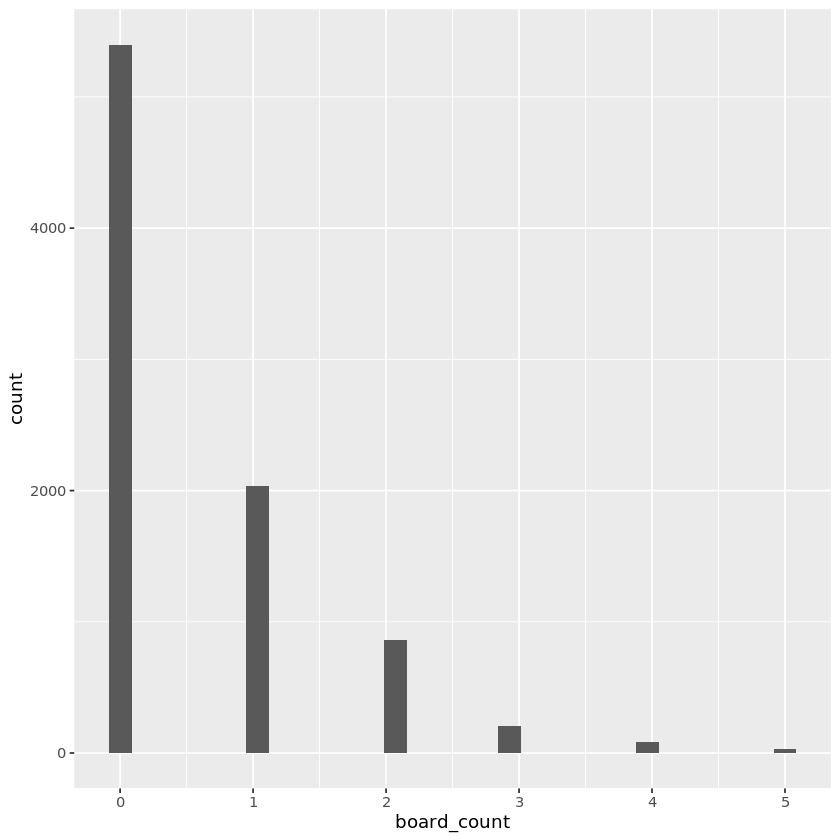

In [140]:
Pre_lock_route1_dir1_bus_stop_124 %>%
    ggplot(aes(board_count)) +
    geom_histogram()